# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
# Import bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t, ks_2samp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# from pycaret.classification import *

from joblib import dump, load

In [3]:
# Carregando base
df = pd.read_feather('./../36_modulo/data/credit_scoring.ftr')
dump(df, "./data/df")
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [4]:
df.head().to_csv("./data/df_head")

In [5]:
# Obtendo amostra da base para a modelagem, devido ao grande número de instâncias
df_copy = df.sample(frac=.1).copy()

# Convertendo renda para log
df_copy['renda_log'] = np.log(df_copy['renda'])

# Obtendo o valor de mês da data de referência
df_copy['month'] = df_copy['data_ref'].dt.month

# Inserindo dados faltantes com média em tempo de emprego
df_copy.fillna({"tempo_emprego": np.mean(df_copy['tempo_emprego'])}, inplace=True)

# Removendo index da base
df_copy.drop('index', axis=1, inplace=True)
df_copy.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month
688163,2016-02-01,M,N,S,1,Empresário,Superior completo,Casado,Casa,36,11.613699,3.0,12324.26,False,9.419325,2
124216,2015-03-01,F,N,S,0,Empresário,Superior completo,Casado,Com os pais,26,7.602740,2.0,2475.93,False,7.814371,3
431058,2015-09-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,51,3.621918,2.0,8613.73,False,9.061113,9
152335,2015-04-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,48,10.345205,1.0,14616.35,False,9.589896,4
603270,2016-01-01,M,S,N,0,Pensionista,Médio,Casado,Casa,51,7.748784,2.0,1161.29,True,7.057287,1


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [6]:
# Instanciando variável com a base de validação
df_valid = df_copy[df_copy['data_ref'] >= '2015-12-01']

# Instanciando variável com a base de teste
df_train = df_copy[df_copy['data_ref'] < '2015-12-01']
print("Treino:")
print(f"Início -> {df_train['data_ref'].min()} \nFim    -> {df_train['data_ref'].max()}")
print()
print("Validação:")
print(f"Início -> {df_valid['data_ref'].min()} \nFim    -> {df_valid['data_ref'].max()}" )

Treino:
Início -> 2015-01-01 00:00:00 
Fim    -> 2015-11-01 00:00:00

Validação:
Início -> 2015-12-01 00:00:00 
Fim    -> 2016-03-01 00:00:00


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
# Descrição da base
print("Treino:")
print(f"Nùm. linhas : {df_train.shape[0]:,.0f}".replace(",","."))
print(f"Nùm. colunas: {df_train.shape[1]:,.0f}".replace(",","."))
print()
print("Validação:")
print(f"Nùm. linhas  : {df_valid.shape[0]:,.0f}".replace(",","."))
print(f"Nùm. colunas : {df_valid.shape[1]:,.0f}".replace(",","."))

Treino:
Nùm. linhas : 55.041
Nùm. colunas: 16

Validação:
Nùm. linhas  : 19.959
Nùm. colunas : 16


In [8]:
# Número de linhas para cada mês em data_ref na base de treino
df_train.groupby("month")['data_ref'].count()

month
1     5043
2     5075
3     4987
4     5033
5     4930
6     4915
7     4999
8     4973
9     5054
10    5095
11    4937
Name: data_ref, dtype: int64

In [9]:
# Número de linhas para cada mês em data_ref na base de teste
df_valid.groupby("month")['data_ref'].count()

month
1     4907
2     5059
3     5028
12    4965
Name: data_ref, dtype: int64

In [10]:
# Verificando as classes das variáveis
df_copy.dtypes

data_ref                 datetime64[ns]
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
renda_log                       float64
month                             int32
dtype: object

In [11]:
# Lista com as posições dos gráficos
ax_index = [
    [0,0],[0,1],[0,2],
    [1,0],[1,1],[1,2],
    [2,0],
]
ax_index

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0]]

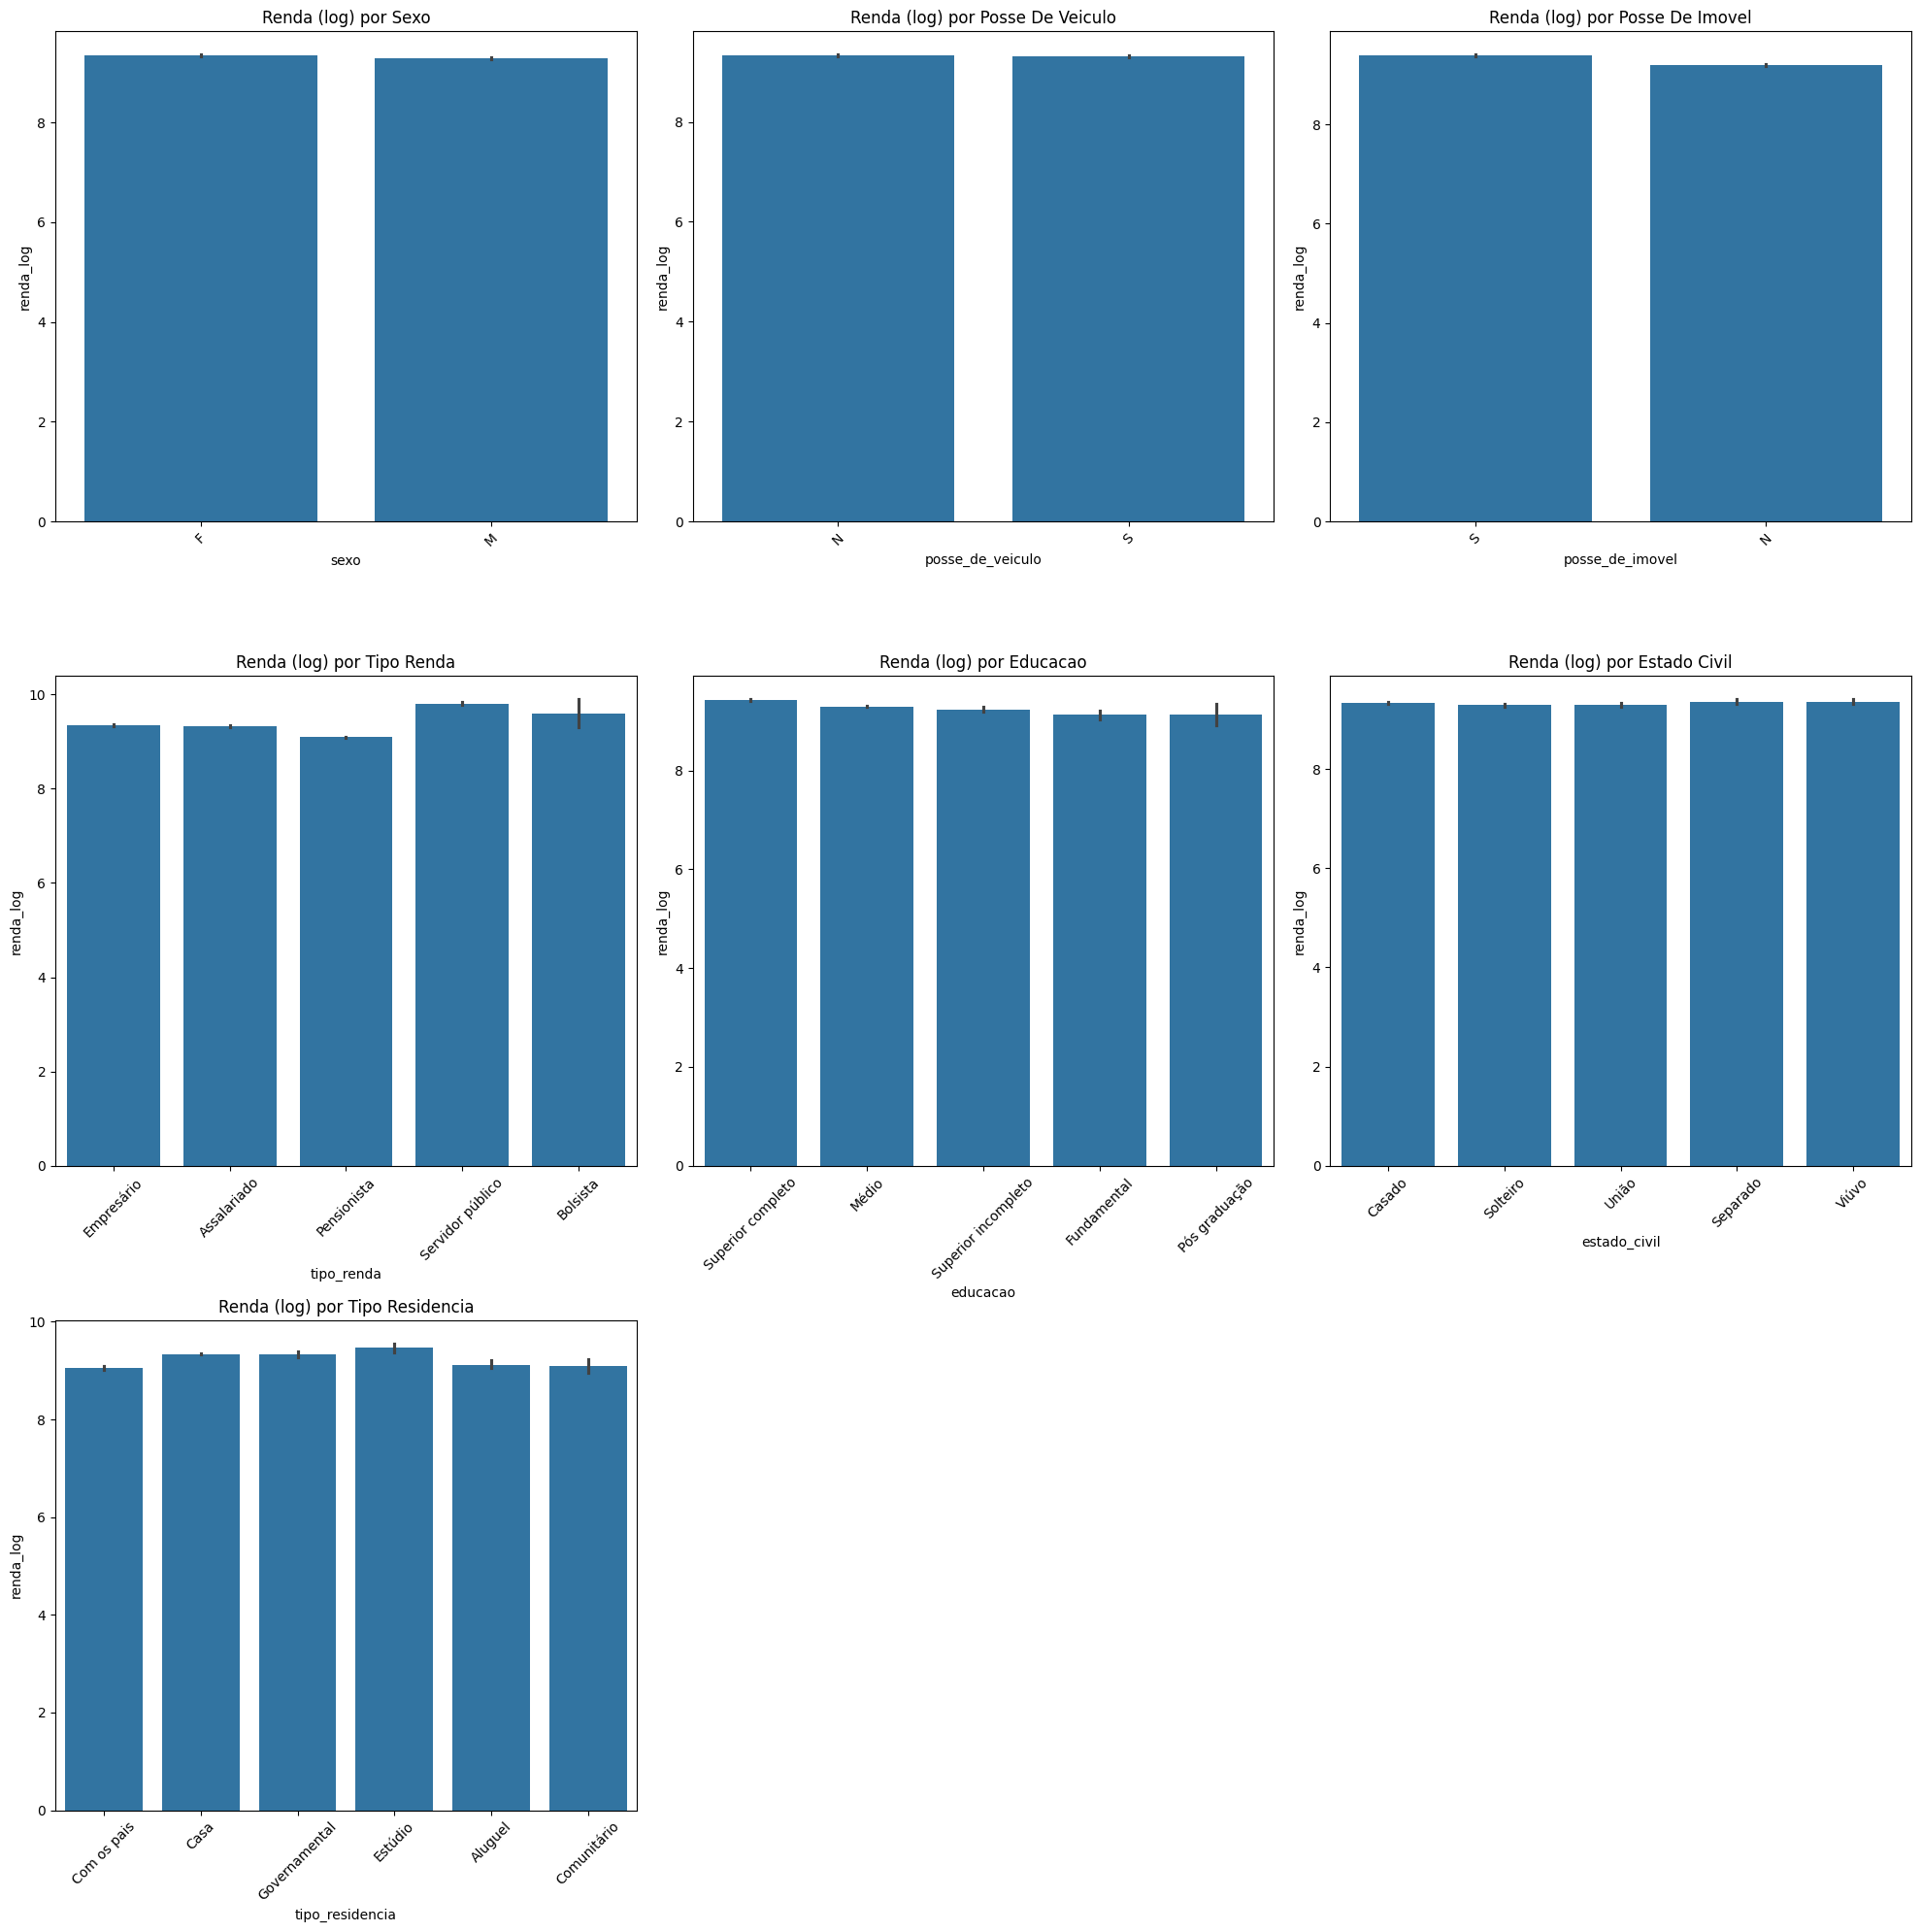

In [12]:
# Análise univariáda de variáveis categóricas, base treino
fig, ax = plt.subplots(3,3, figsize=(20,20))
for k, v in enumerate(df_copy.select_dtypes("object").dtypes.index):
    g = sns.barplot(
        x=v,
        y='renda_log',
        data=df_train,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.show()

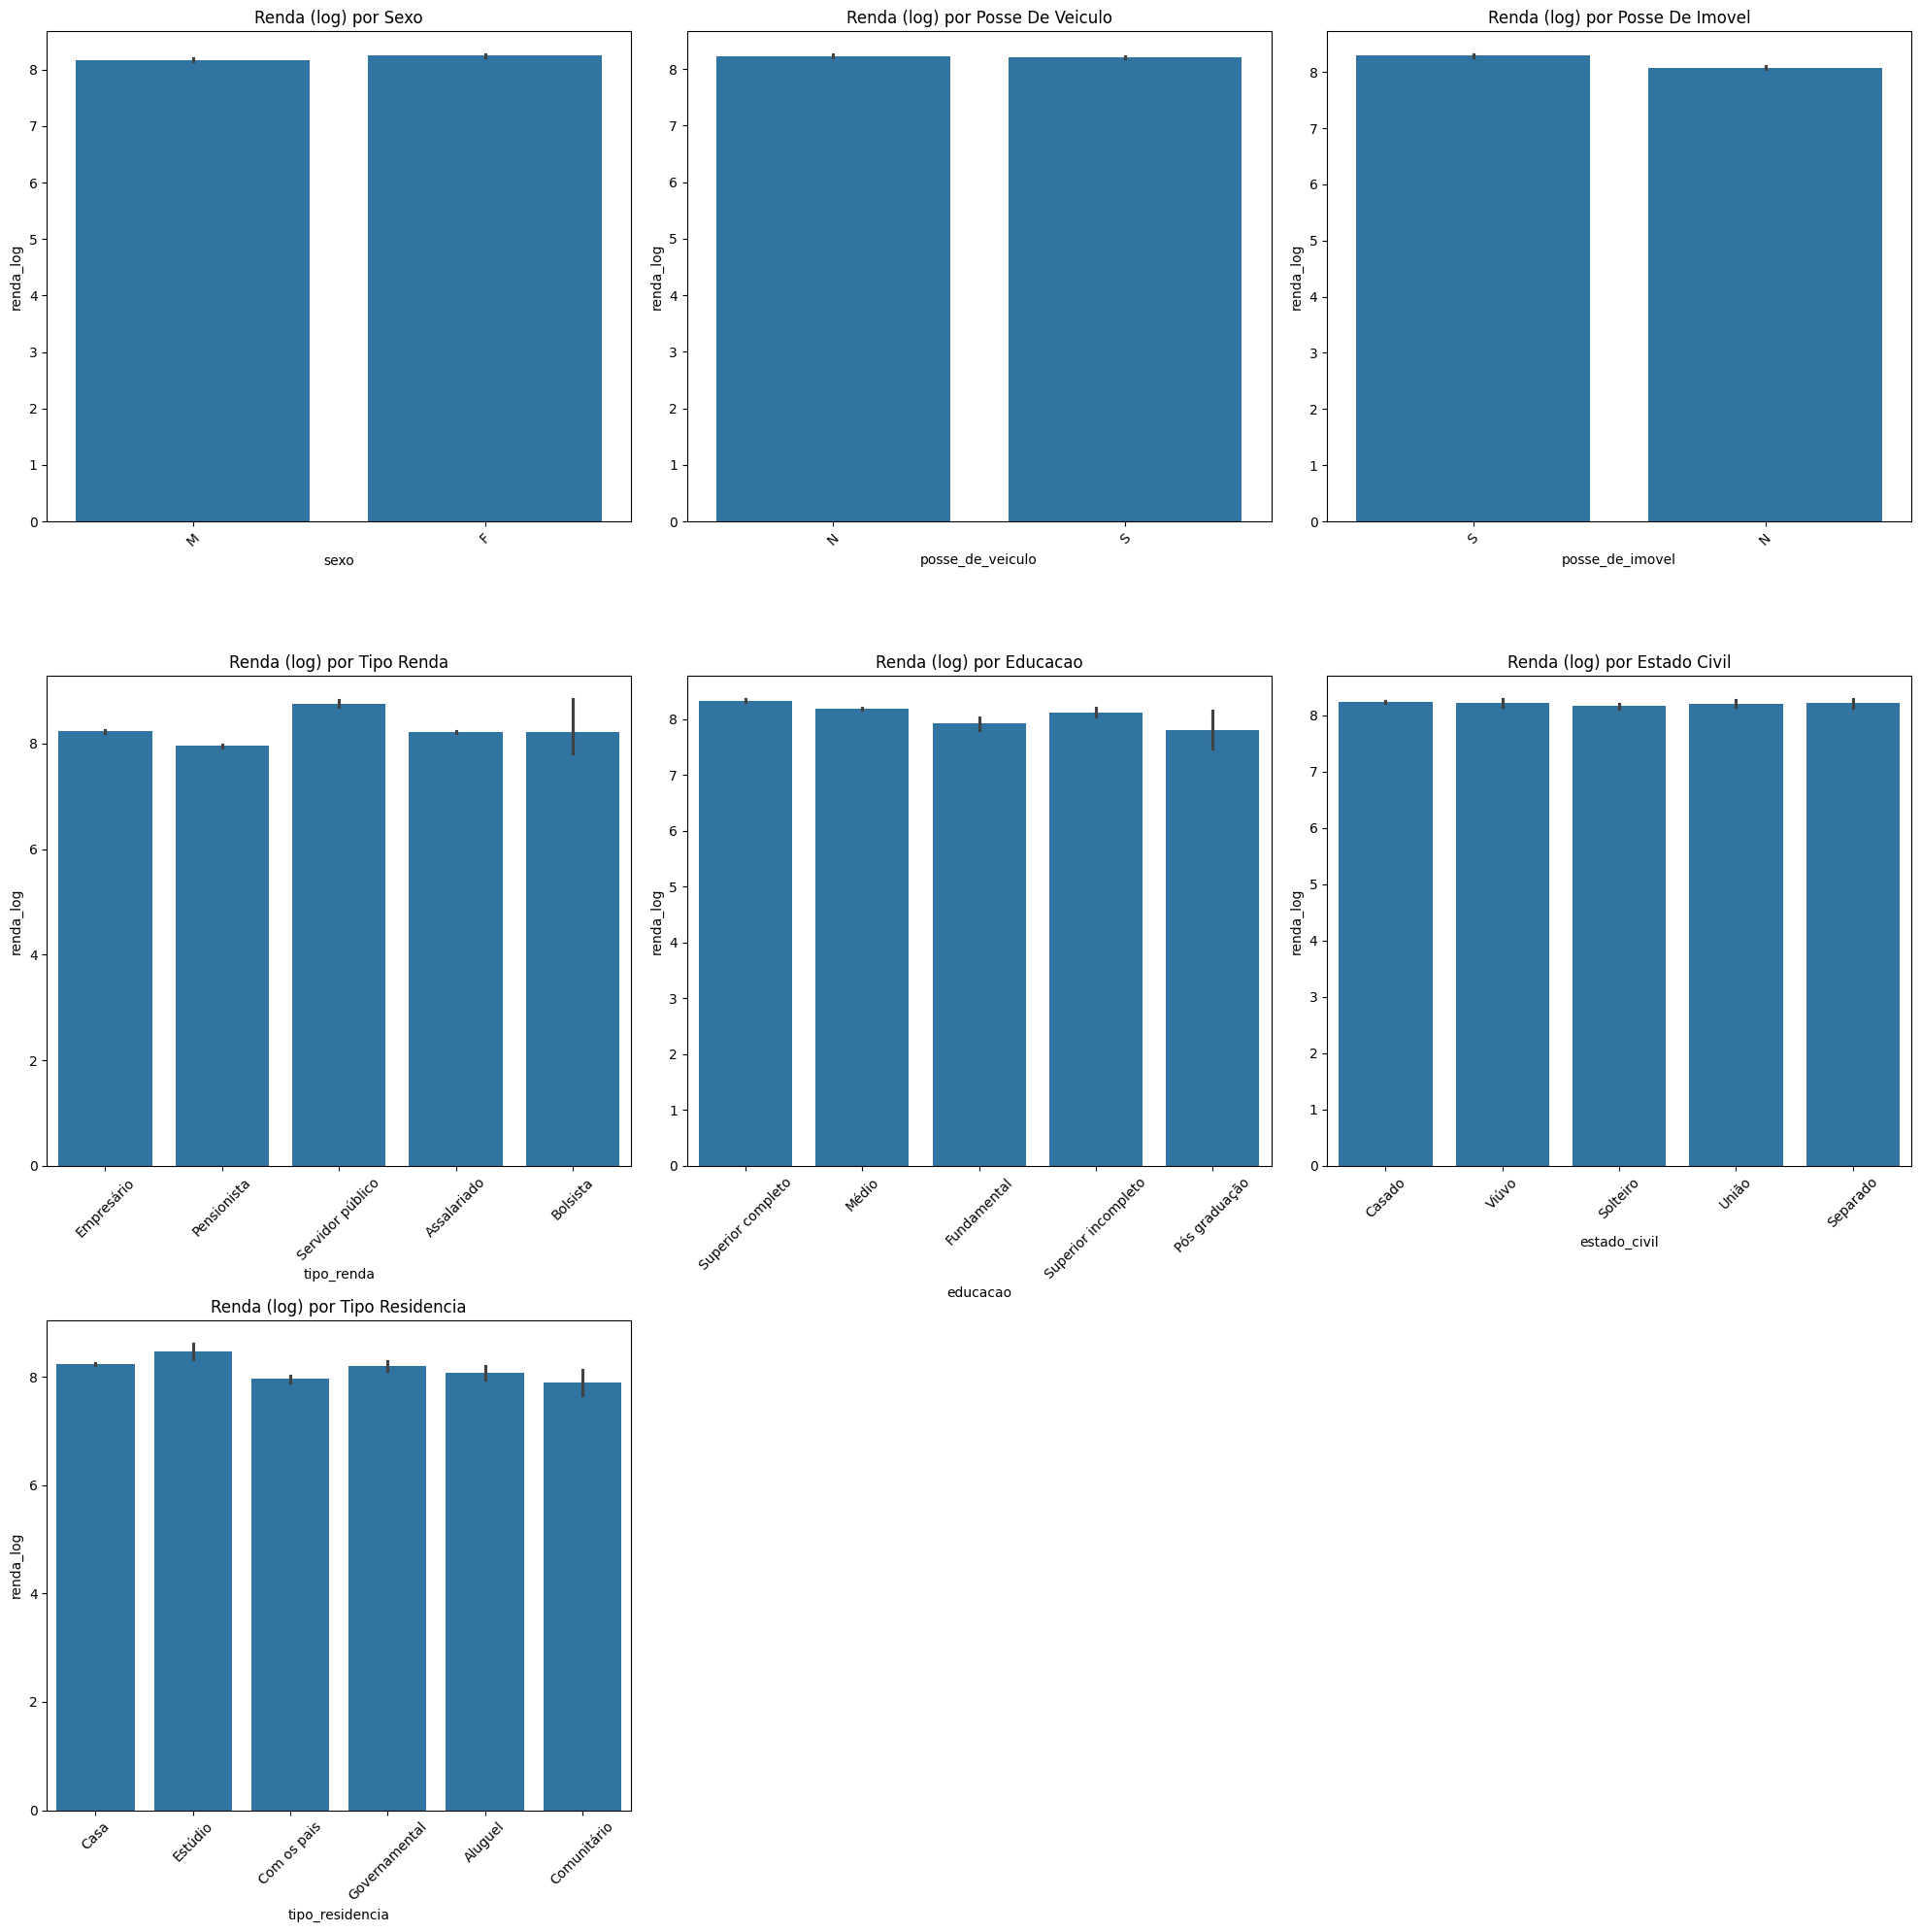

In [13]:
# Análise univariáda de variáveis categóricas, base validação
fig, ax = plt.subplots(3,3, figsize=(20,20))
for k, v in enumerate(df_copy.select_dtypes("object").dtypes.index):
    g = sns.barplot(
        x=v,
        y='renda_log',
        data=df_valid,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.show()

In [14]:
# Variáveis contínuas e discretas
df_train.select_dtypes(["float64","int32"]).dtypes.index

Index(['tempo_emprego', 'qt_pessoas_residencia', 'renda', 'renda_log',
       'month'],
      dtype='object')

<function matplotlib.pyplot.show(close=None, block=None)>

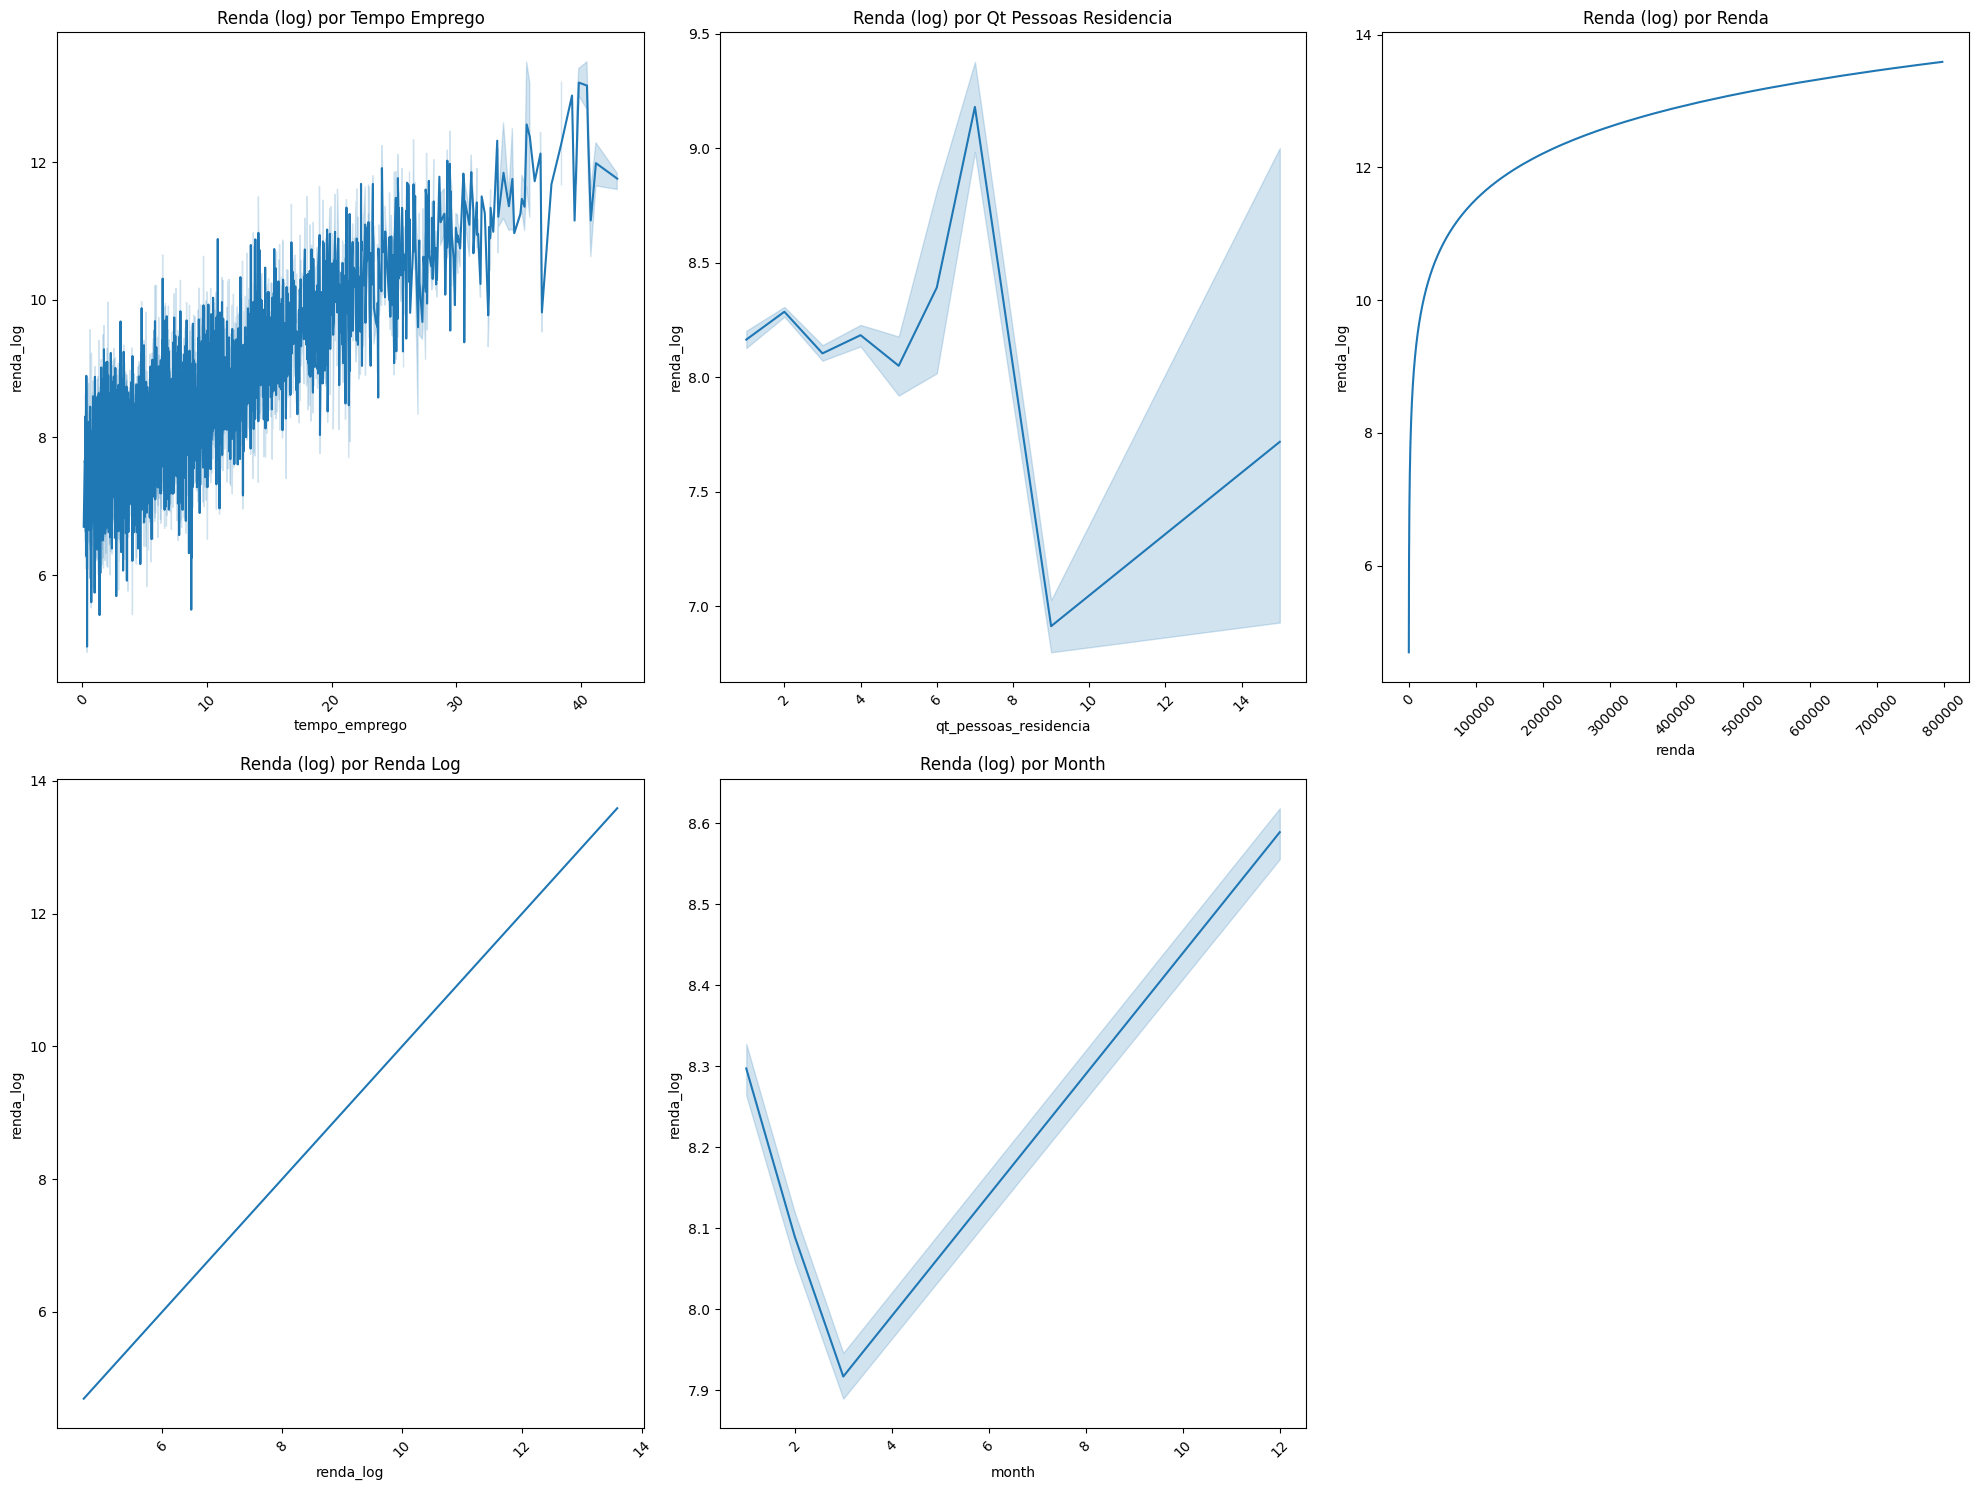

In [15]:
# Análise univariáda de variáveis numéricas, base validação
fig, ax = plt.subplots(2, 3, figsize=(20,15))
for k, v in enumerate(df_train.select_dtypes(["float64","int32"]).dtypes.index):
    g = sns.lineplot(
        x=v,
        y='renda_log',
        data=df_valid.replace([np.inf, -np.inf], np.nan),
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[1,2].set_axis_off()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

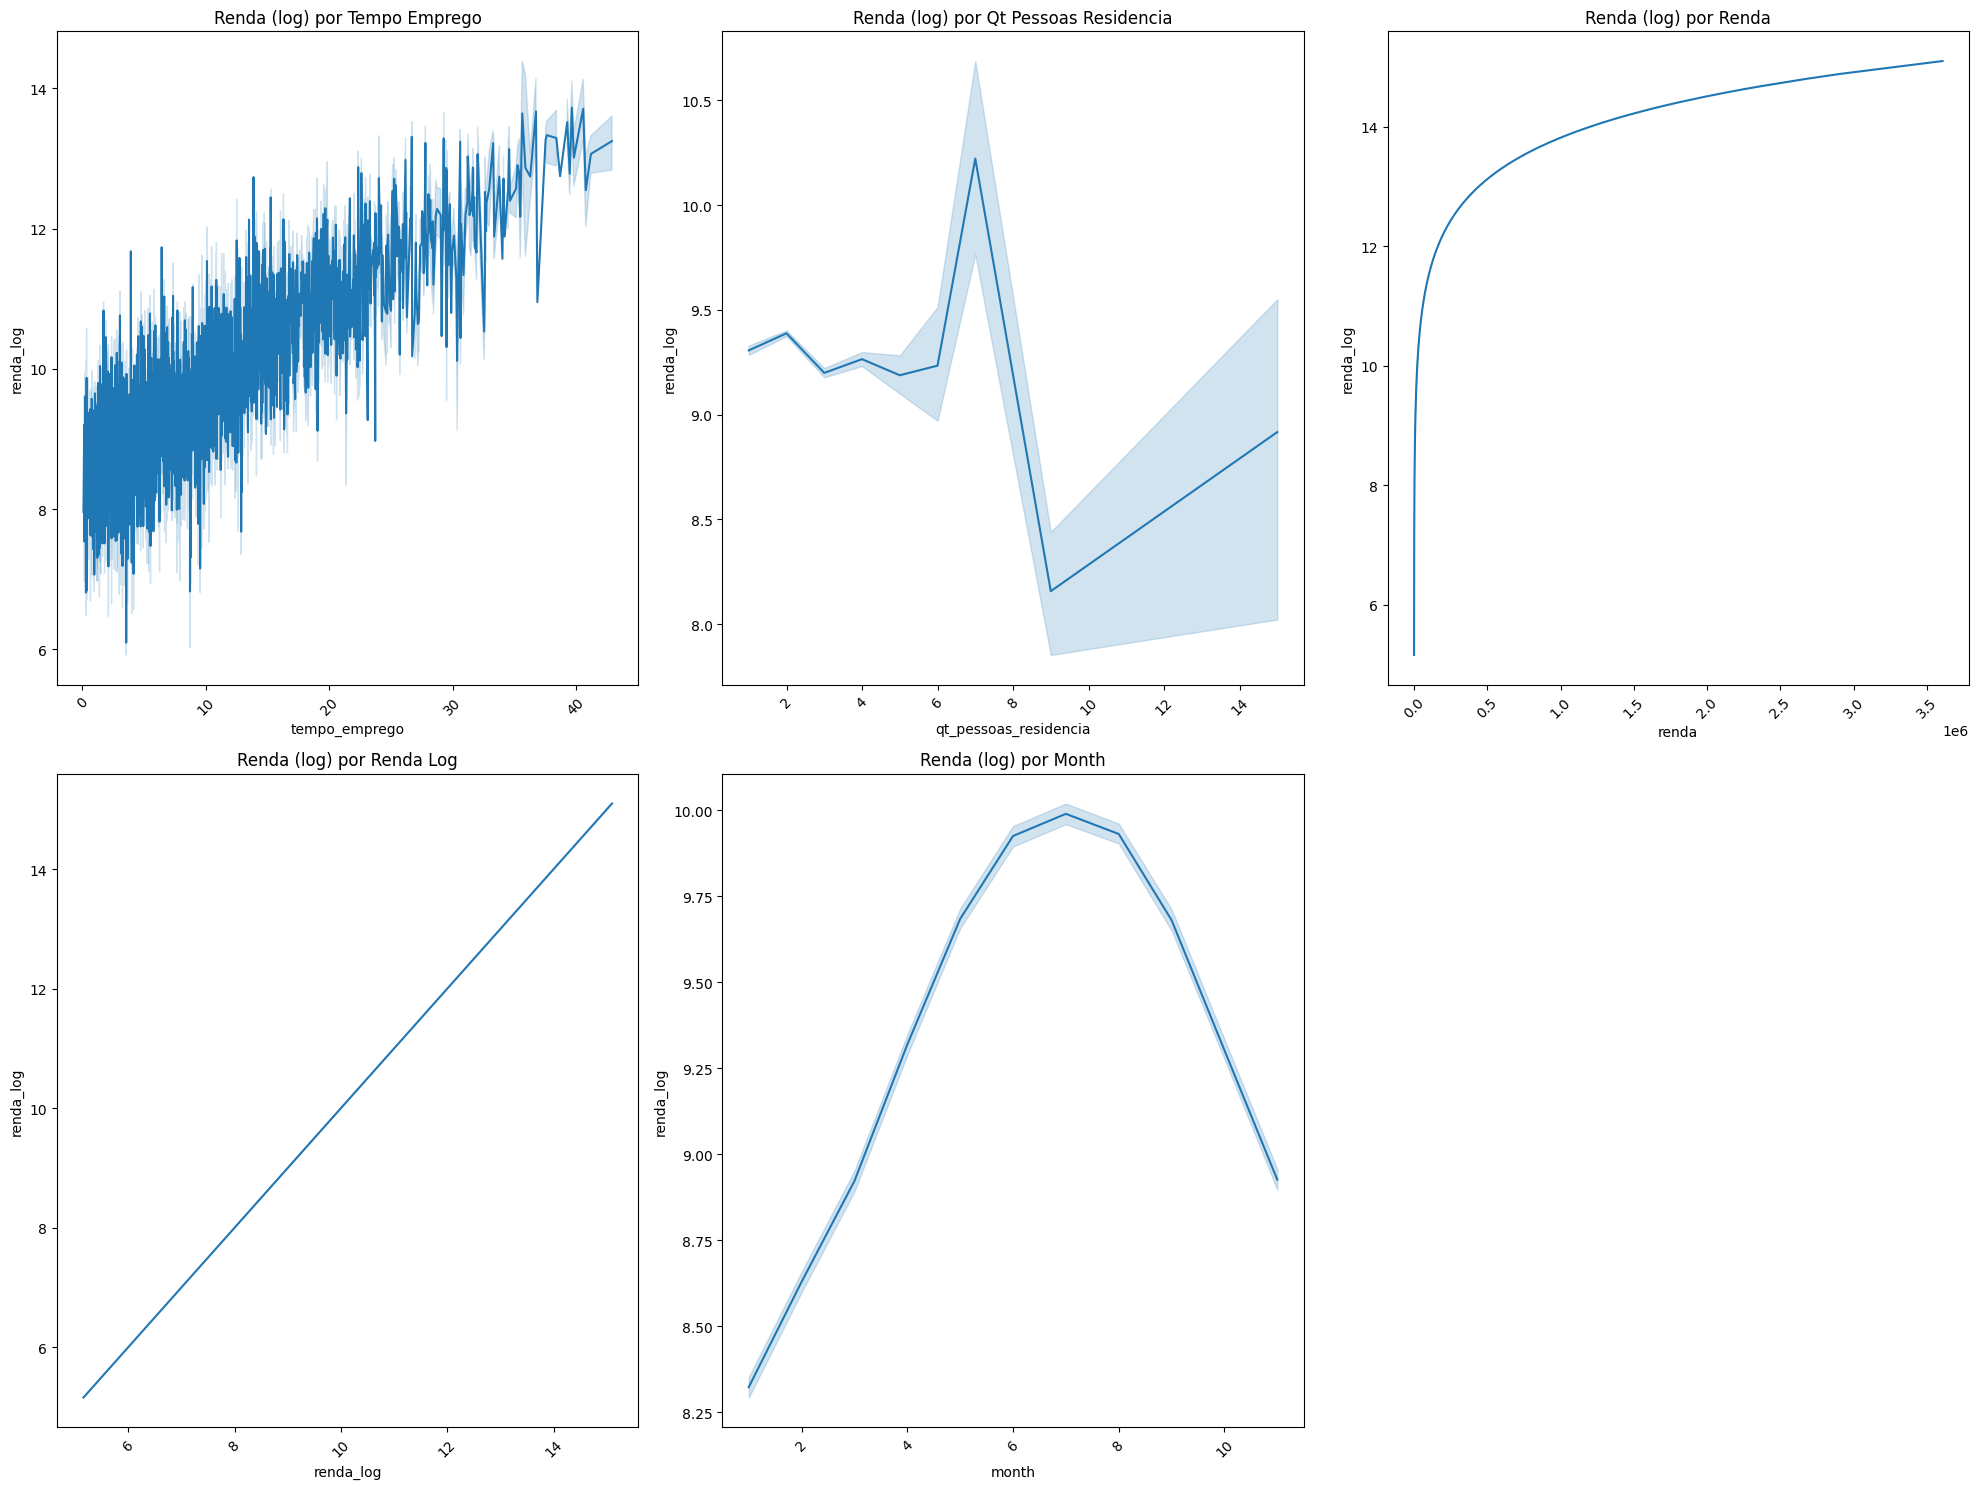

In [16]:
# Análise univariáda de variáveis numéricas, base treino
fig, ax = plt.subplots(2, 3, figsize=(20,15))
for k, v in enumerate(df_train.select_dtypes(["float64","int32"]).dtypes.index):
    g = sns.lineplot(
        x=v,
        y='renda_log',
        data=df_train.replace([np.inf, -np.inf], np.nan),
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[1,2].set_axis_off()
plt.show

## Conclusão
- Observa-se que todas as analises univariadass retornam informações que podem ser consideradas consistentes para a distribuição de valores em relação a variável resposta

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [17]:
# Função de gráfico e calculos WOE
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    _, ax = plt.subplots(2,1, figsize=(20, 8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()
    return biv

In [18]:
# Variáveis categóricas da base
categorias = df_train.select_dtypes("object").dtypes.index
categorias

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object')

#### Base Teste

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,35025,2134,0.057429,F,37159,0.001207,0.059795,0.055063,-2.798064,-2.755184,-2.842636,0.036824,0.079704,-0.007748
M,16963,919,0.051392,M,17882,0.001651,0.054629,0.048156,-2.915504,-2.851015,-2.983954,-0.080615,-0.016127,-0.149066


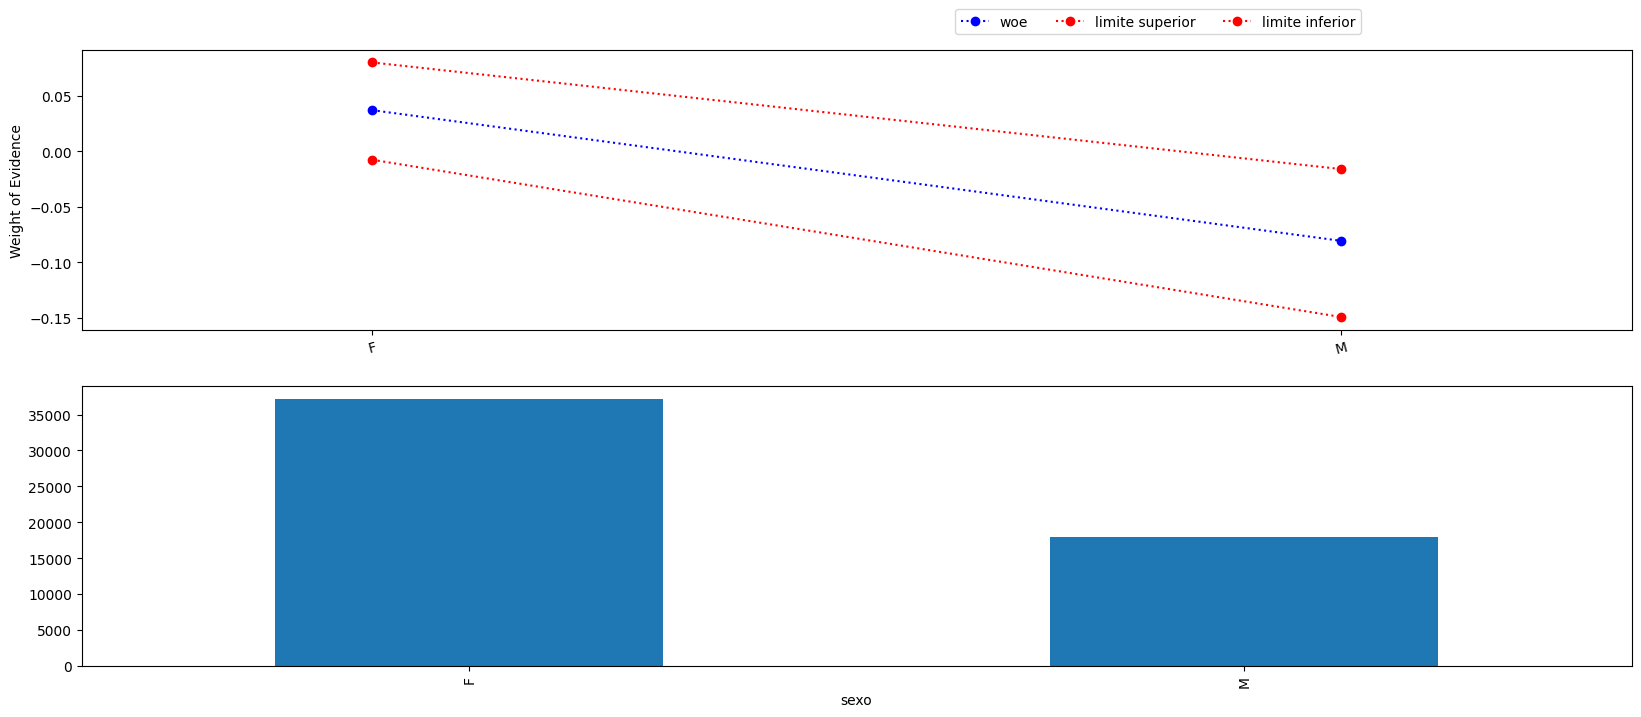

In [19]:
# Sexo
c = 0
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,31773,1919,0.056957,N,33692,0.001263,0.059432,0.054482,-2.806813,-2.761652,-2.853856,0.028076,0.073236,-0.018968
S,20215,1134,0.053117,S,21349,0.001535,0.056126,0.050109,-2.880674,-2.822398,-2.942152,-0.045785,0.012490,-0.107264


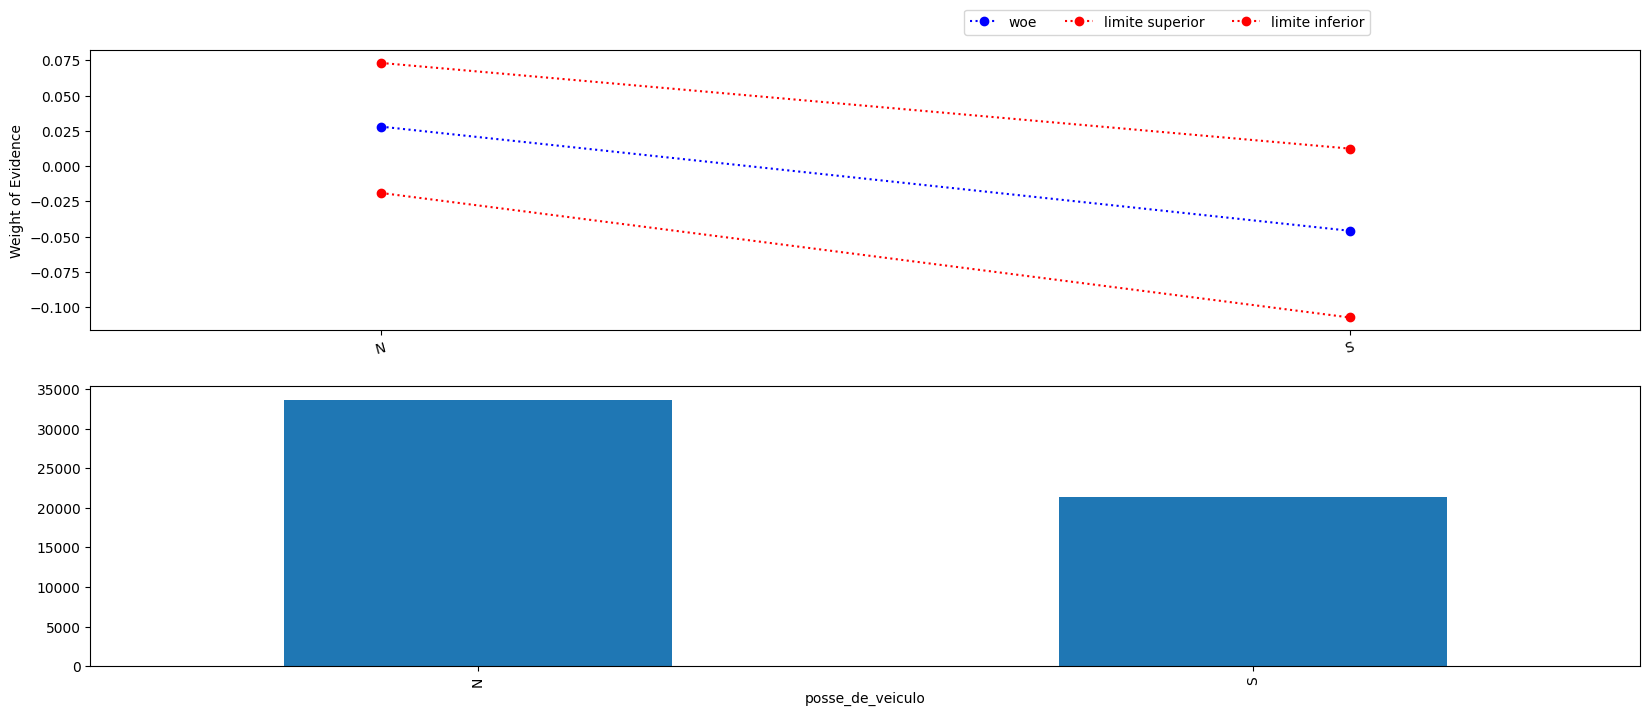

In [20]:
# Posse De Veículo
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,16897,1136,0.062996,N,18033,0.001809,0.066542,0.059449,-2.699623,-2.641065,-2.761340,0.135265,0.193823,0.073548
S,35091,1917,0.051800,S,37008,0.001152,0.054058,0.049542,-2.907183,-2.862131,-2.954132,-0.072295,-0.027243,-0.119244


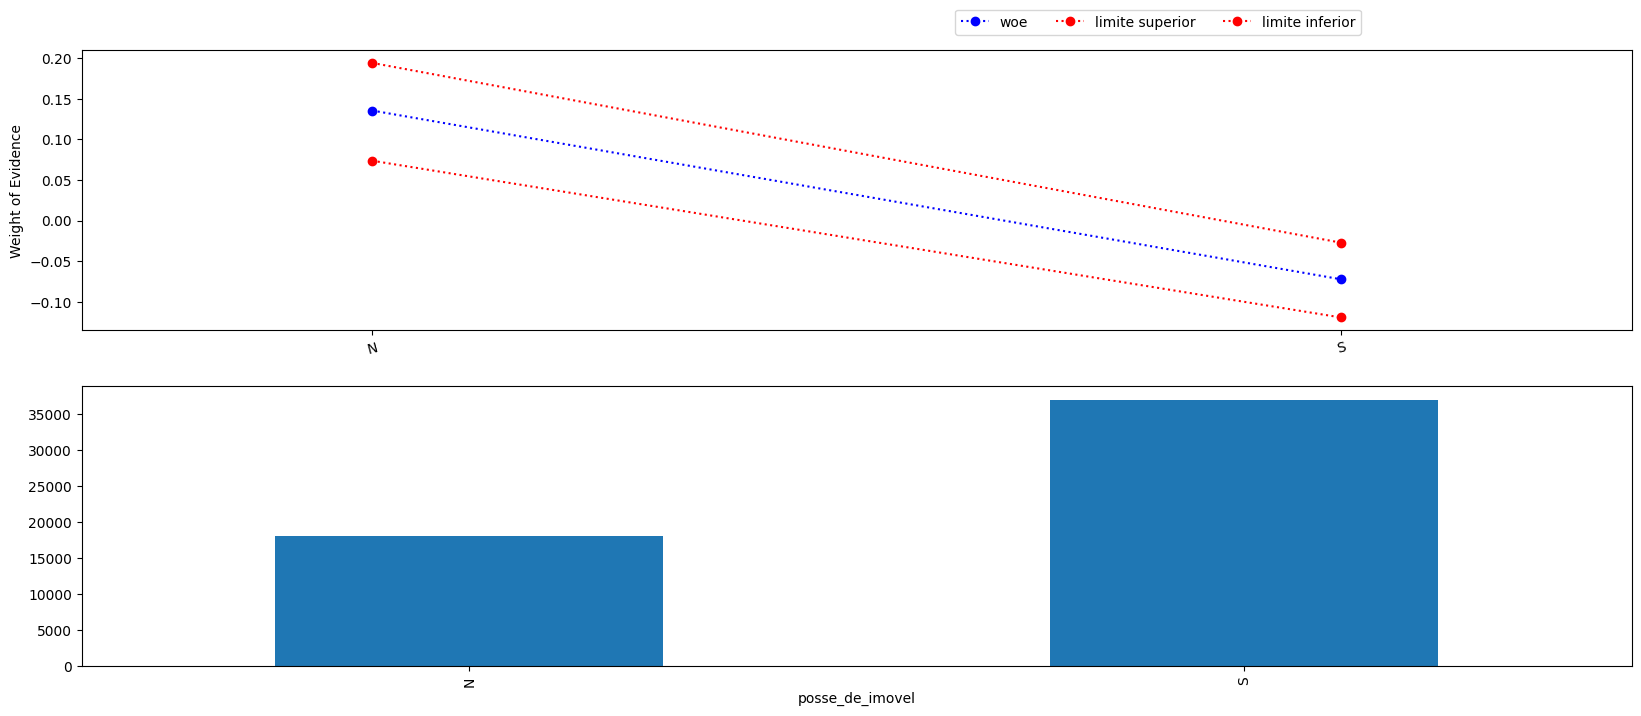

In [21]:
# Posse De Imóvel
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,26684,1627,0.057469,Assalariado,28311,0.001383,0.060180,0.054758,-2.797326,-2.748349,-2.848524,0.037562,0.086539,-0.013635
Bolsista,30,2,0.062500,Bolsista,32,0.042791,0.149772,-0.024772,-2.708050,-1.736387,NaN,0.126838,1.098501,NaN
Empresário,11922,689,0.054635,Empresário,12611,0.002024,0.058602,0.050668,-2.850899,-2.776602,-2.930465,-0.016011,0.058286,-0.095577
Pensionista,8728,543,0.058570,Pensionista,9271,0.002439,0.063350,0.053789,-2.777182,-2.693631,-2.867392,0.057706,0.141257,-0.032504
Servidor público,4624,192,0.039867,Servidor público,4816,0.002819,0.045394,0.034340,-3.181520,-3.045917,-3.336497,-0.346632,-0.211029,-0.501609


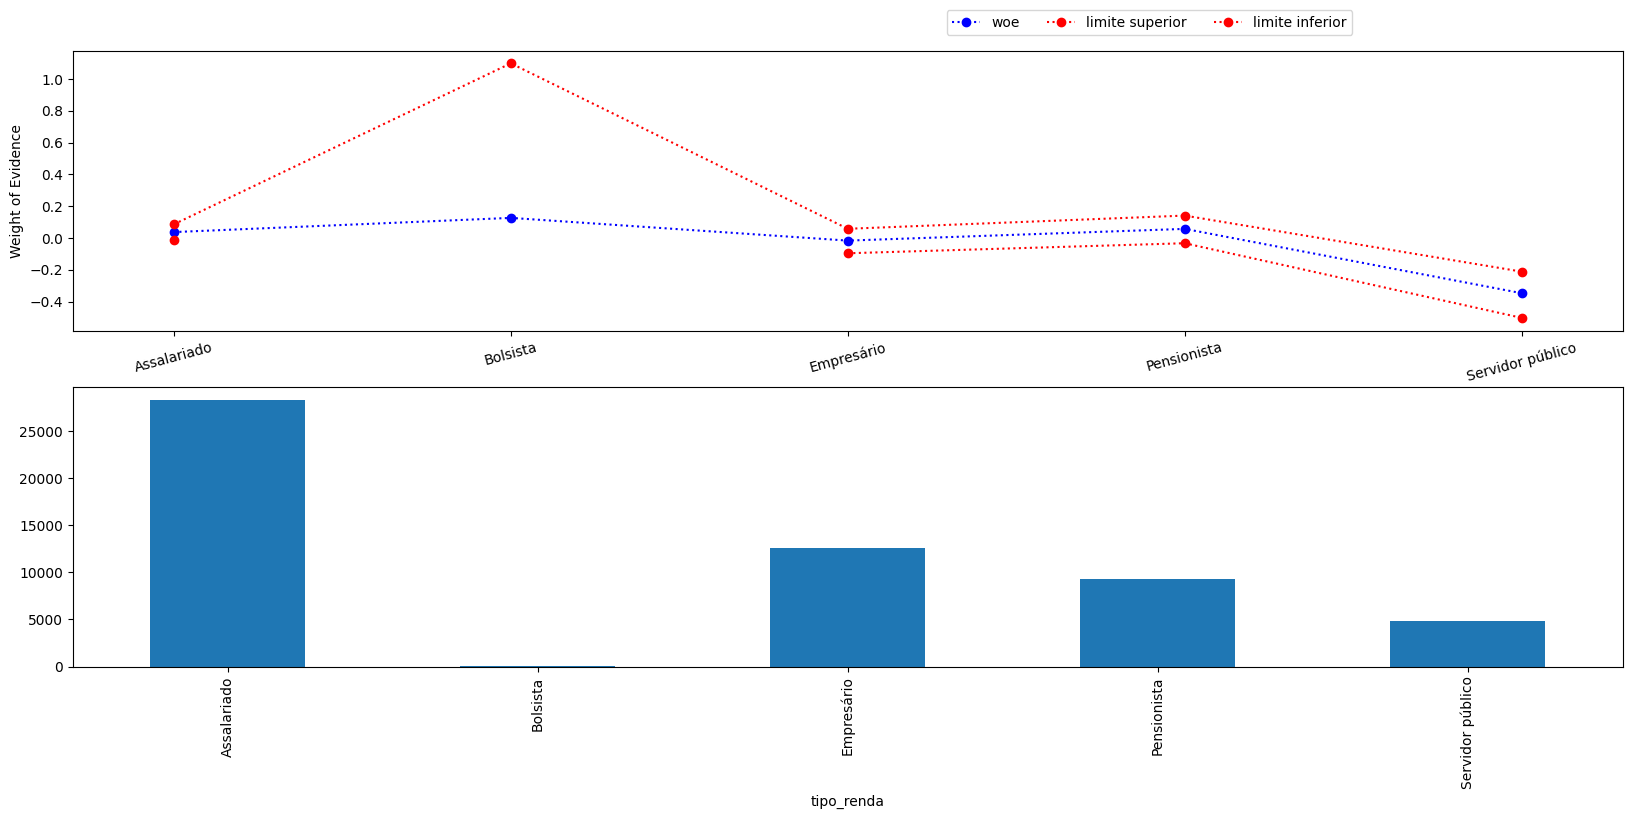

In [22]:
# Tipo Renda
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,574,32,0.052805,Fundamental,606,0.009085,0.070647,0.034963,-2.886893,-2.576791,-3.317863,-0.052005,0.258097,-0.482975
Médio,35034,2137,0.057491,Médio,37171,0.001207,0.059858,0.055125,-2.796916,-2.754064,-2.841457,0.037972,0.080824,-0.006569
Pós graduação,47,2,0.040816,Pós graduação,49,0.028266,0.097650,-0.016017,-3.157000,-2.223617,NaN,-0.322112,0.611271,NaN
Superior completo,14306,757,0.050256,Superior completo,15063,0.001780,0.053745,0.046766,-2.939071,-2.868266,-3.014695,-0.104183,-0.033378,-0.179806
Superior incompleto,2027,125,0.058086,Superior incompleto,2152,0.005042,0.067974,0.048197,-2.785998,-2.618242,-2.983052,0.048890,0.216646,-0.148163


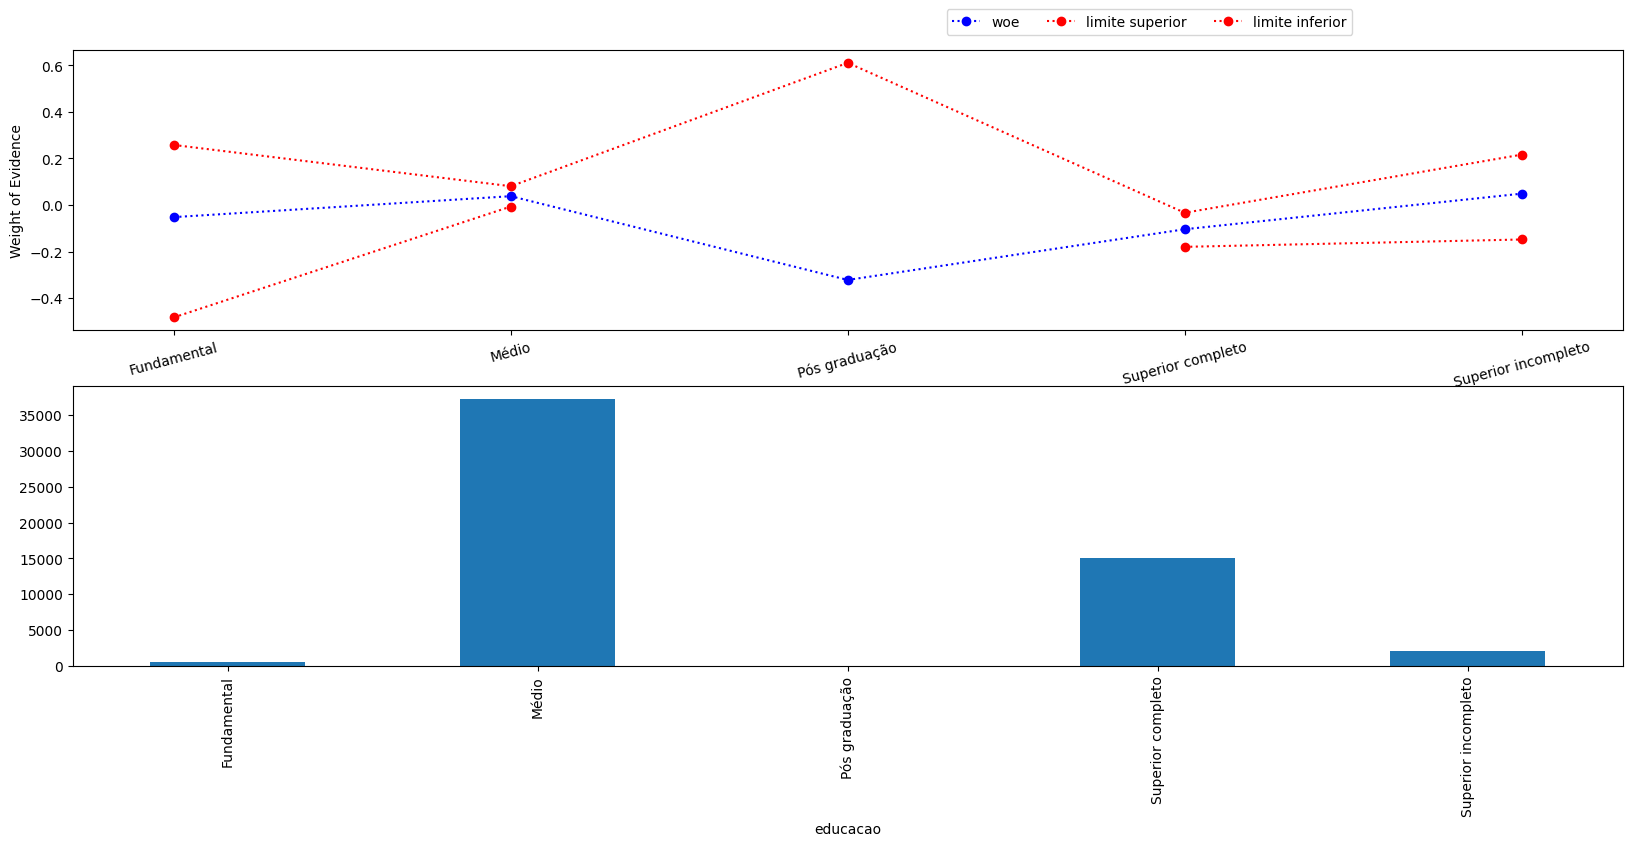

In [23]:
# Educação
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,36662,2080,0.053689,Casado,38742,0.001145,0.055933,0.051444,-2.869373,-2.826042,-2.914448,-0.034485,0.008847,-0.079560
Separado,2945,171,0.054878,Separado,3116,0.004080,0.062878,0.046879,-2.846201,-2.701625,-3.012182,-0.011312,0.133263,-0.177293
Solteiro,6216,406,0.061311,Solteiro,6622,0.002948,0.067090,0.055532,-2.728529,-2.632275,-2.833669,0.106359,0.202613,0.001219
União,3935,264,0.062872,União,4199,0.003746,0.070216,0.055528,-2.701717,-2.583375,-2.833735,0.133171,0.251513,0.001153
Viúvo,2230,132,0.055885,Viúvo,2362,0.004726,0.065153,0.046617,-2.826955,-2.663646,-3.018057,0.007933,0.171243,-0.183169


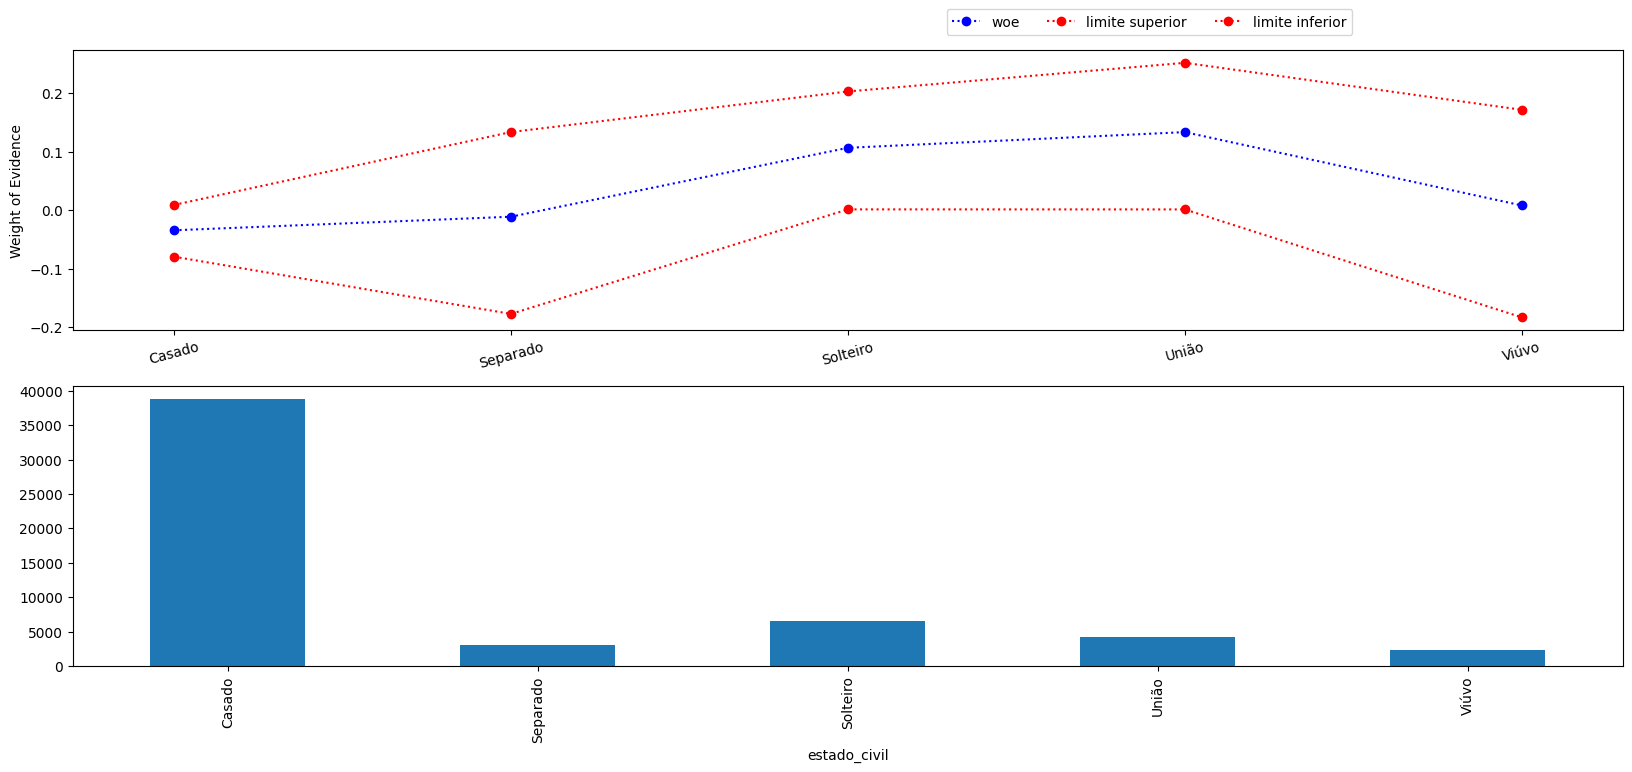

In [24]:
# Estado Civil
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,706,56,0.073491,Aluguel,762,0.009453,0.092048,0.054934,-2.534264,-2.288886,-2.845122,0.300625,0.546002,-0.010234
Casa,46735,2731,0.055210,Casa,49466,0.001027,0.057222,0.053197,-2.839826,-2.801886,-2.879090,-0.004937,0.033002,-0.044202
Com os pais,2223,150,0.063211,Com os pais,2373,0.004995,0.073007,0.053415,-2.695978,-2.541392,-2.874762,0.138911,0.293496,-0.039874
Comunitário,253,12,0.045283,Comunitário,265,0.012773,0.070432,0.020134,-3.048483,-2.580068,-3.885020,-0.213595,0.254821,-1.050131
Estúdio,402,21,0.049645,Estúdio,423,0.010561,0.070404,0.028886,-2.951930,-2.580493,-3.515075,-0.117041,0.254395,-0.680187
Governamental,1669,83,0.047374,Governamental,1752,0.005075,0.057329,0.037420,-3.001139,-2.799914,-3.247411,-0.166251,0.034974,-0.412522


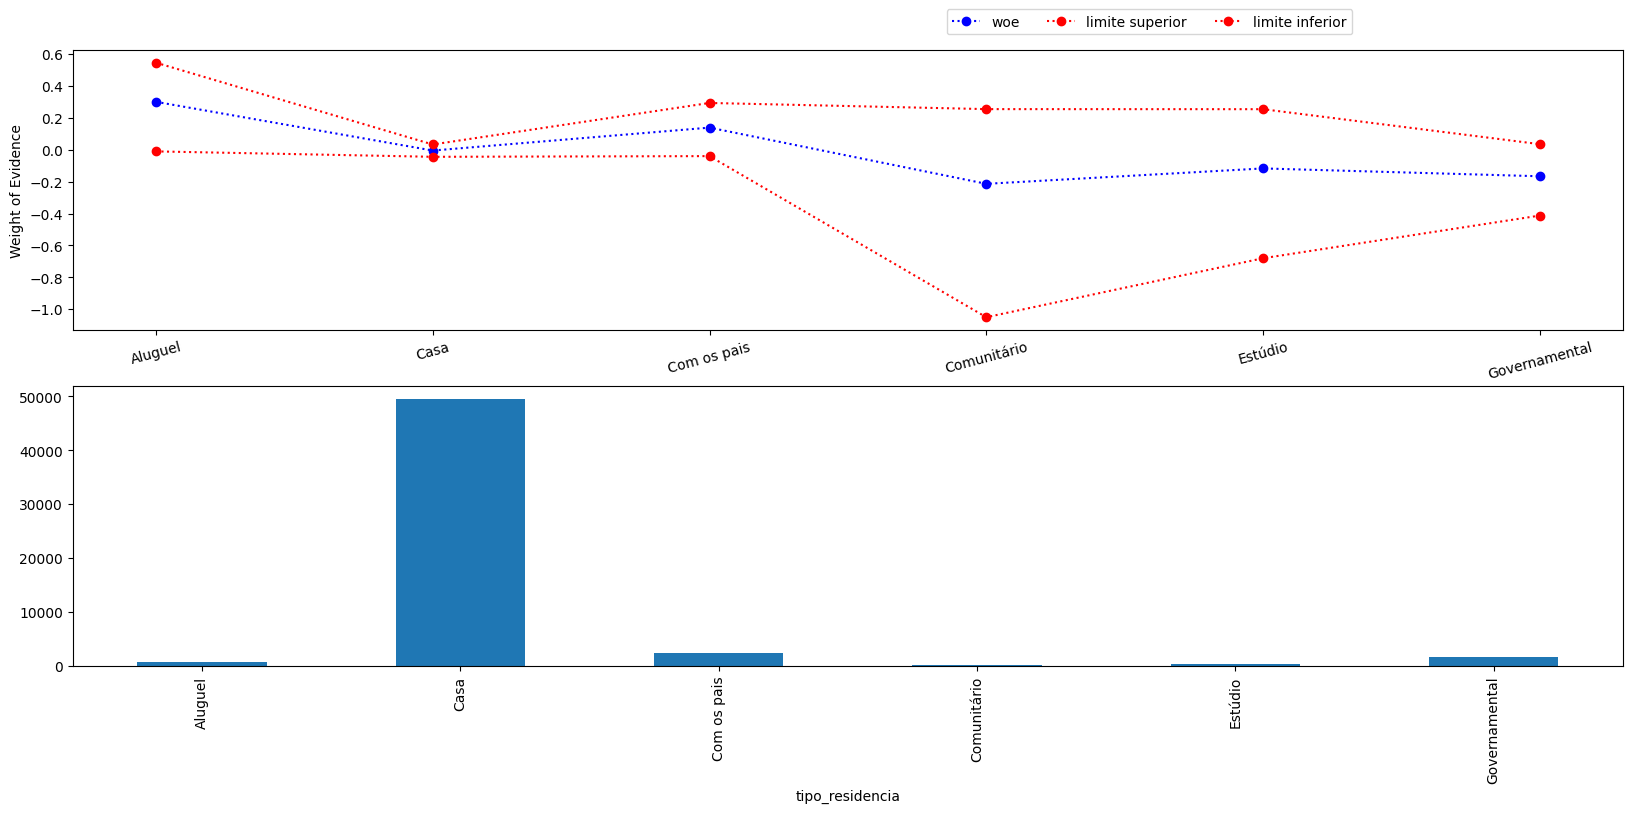

In [25]:
# Tipo Residência
c += 1
biv_discreta(var=categorias[c], df=df_train)

#### Base Validação

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,11616,1872,0.138790,F,13488,0.002977,0.144625,0.132955,-1.825376,-1.777395,-1.875081,0.032278,0.080259,-0.017426
M,5649,822,0.127028,M,6471,0.004140,0.135143,0.118913,-1.927493,-1.856227,-2.002763,-0.069839,0.001427,-0.145108


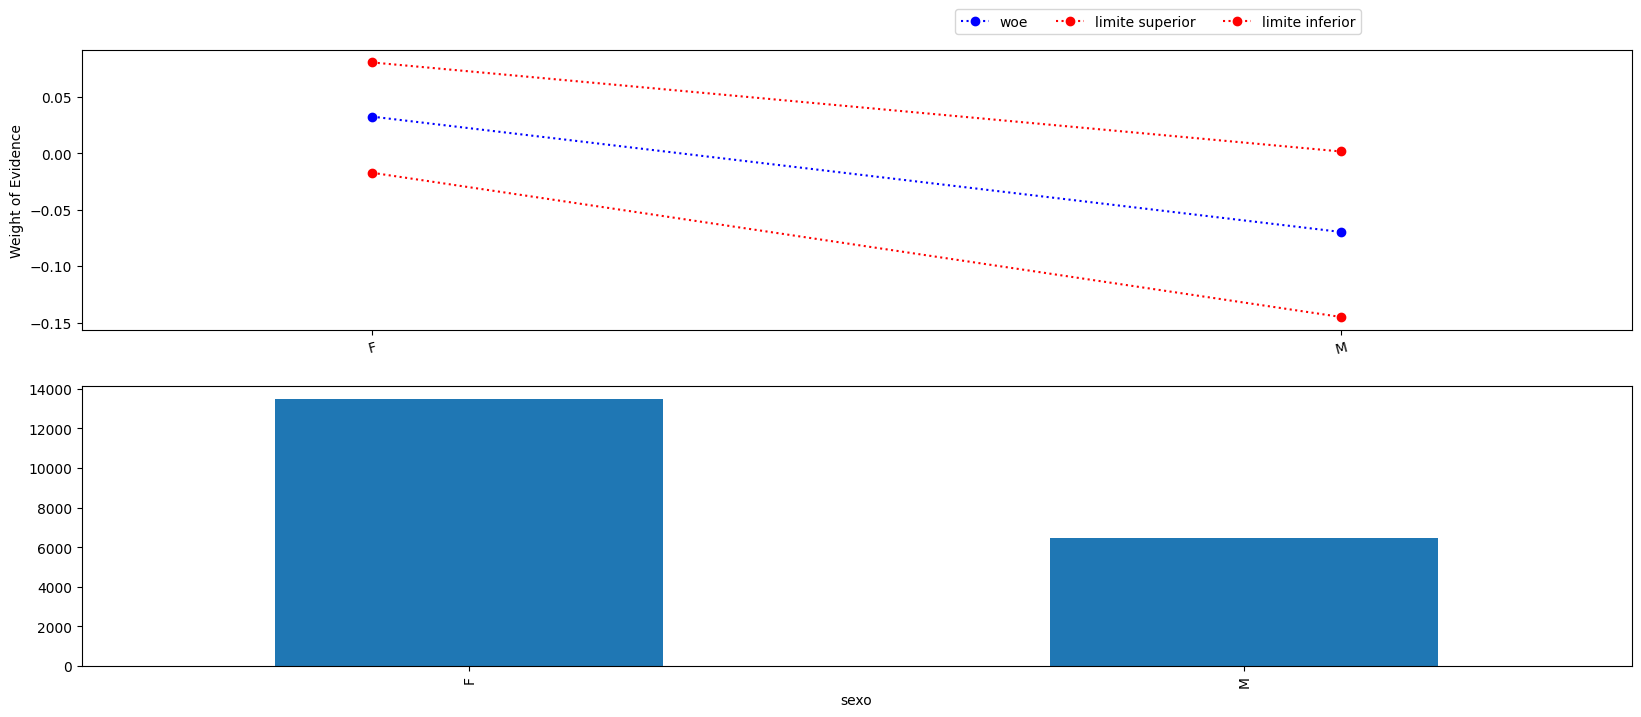

In [26]:
c = 0
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,10586,1656,0.135272,N,12242,0.003091,0.141331,0.129213,-1.855127,-1.804278,-1.907936,0.002527,0.053376,-0.050282
S,6679,1038,0.134508,S,7717,0.003884,0.142122,0.126894,-1.861672,-1.797776,-1.928700,-0.004018,0.059878,-0.071046


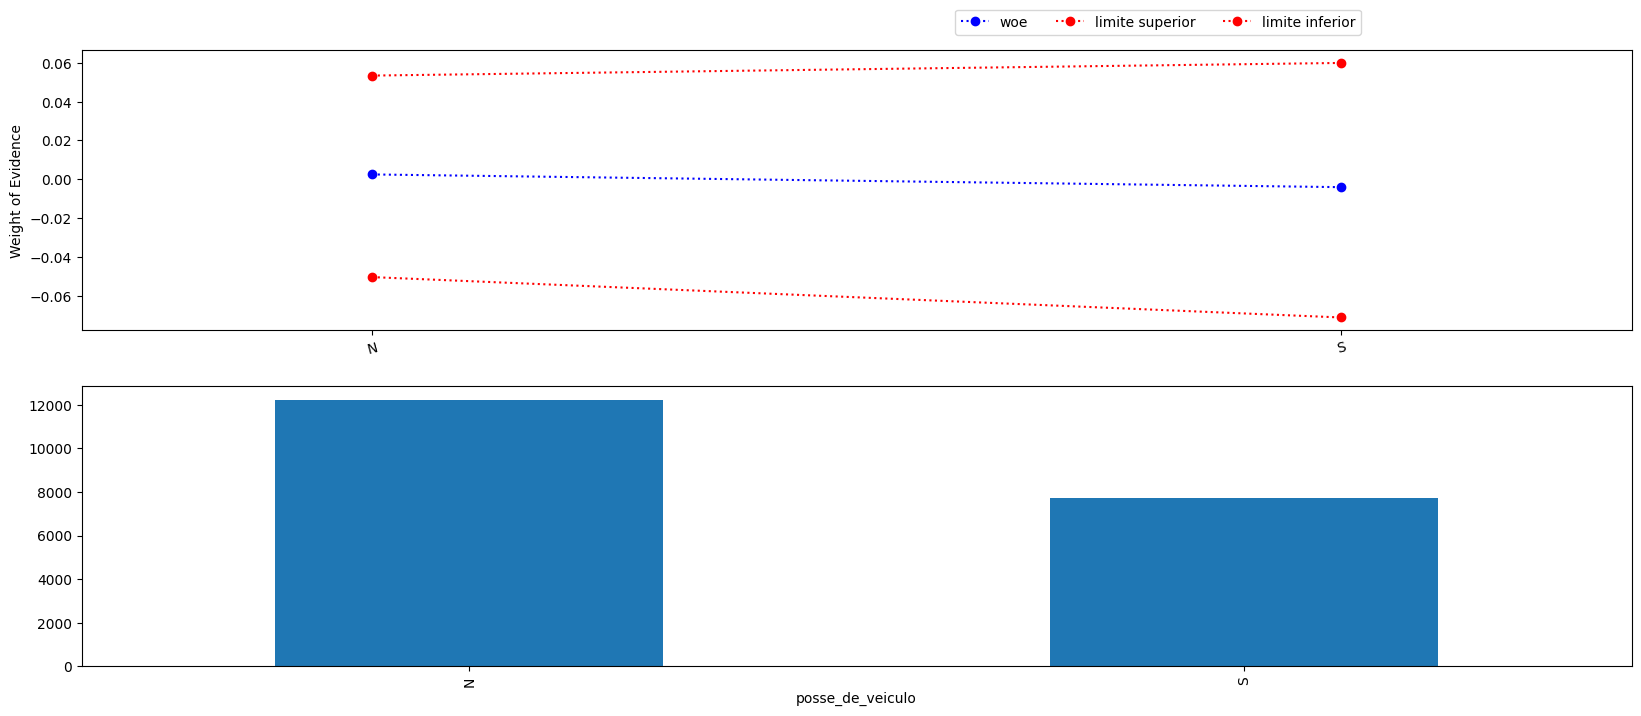

In [27]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,5537,979,0.150246,N,6516,0.004426,0.158923,0.141568,-1.732676,-1.666264,-1.802325,0.124978,0.191390,0.055329
S,11728,1715,0.127576,S,13443,0.002877,0.133216,0.121936,-1.922566,-1.872820,-1.974227,-0.064912,-0.015165,-0.116573


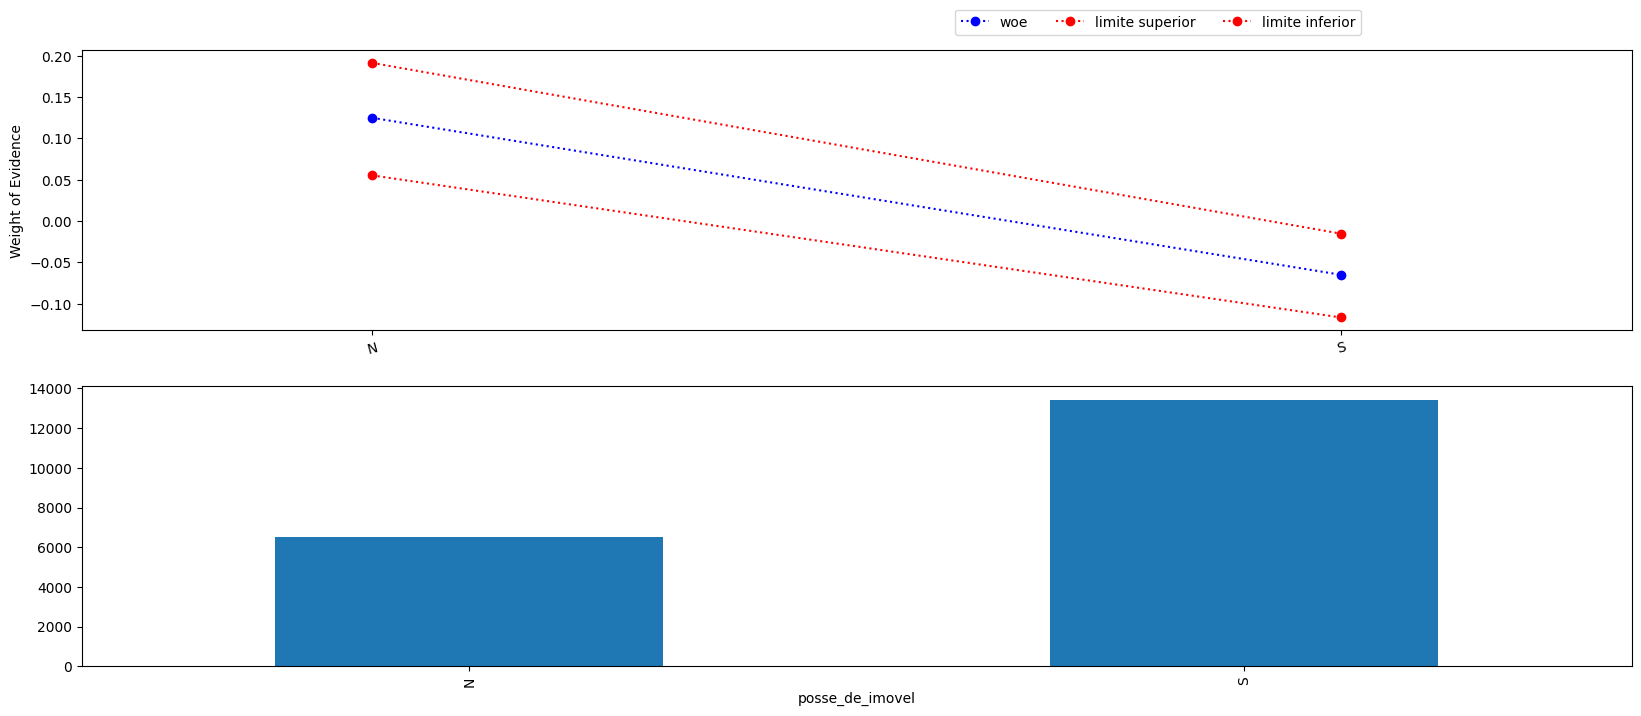

In [28]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,8822,1435,0.139904,Assalariado,10257,0.003425,0.146618,0.133191,-1.816084,-1.761373,-1.873039,0.041571,0.096281,-0.015385
Bolsista,5,1,0.166667,Bolsista,6,0.152145,0.557768,-0.224435,-1.609438,0.232109,NaN,0.248216,2.089764,NaN
Empresário,4029,584,0.126599,Empresário,4613,0.004896,0.136197,0.117000,-1.931373,-1.847242,-2.021146,-0.073718,0.010412,-0.163492
Pensionista,2856,516,0.153025,Pensionista,3372,0.006200,0.165181,0.140869,-1.711071,-1.620177,-1.808089,0.146584,0.237478,0.049566
Servidor público,1553,158,0.092344,Servidor público,1711,0.006999,0.106071,0.078616,-2.285349,-2.131515,-2.461301,-0.427695,-0.273861,-0.603647


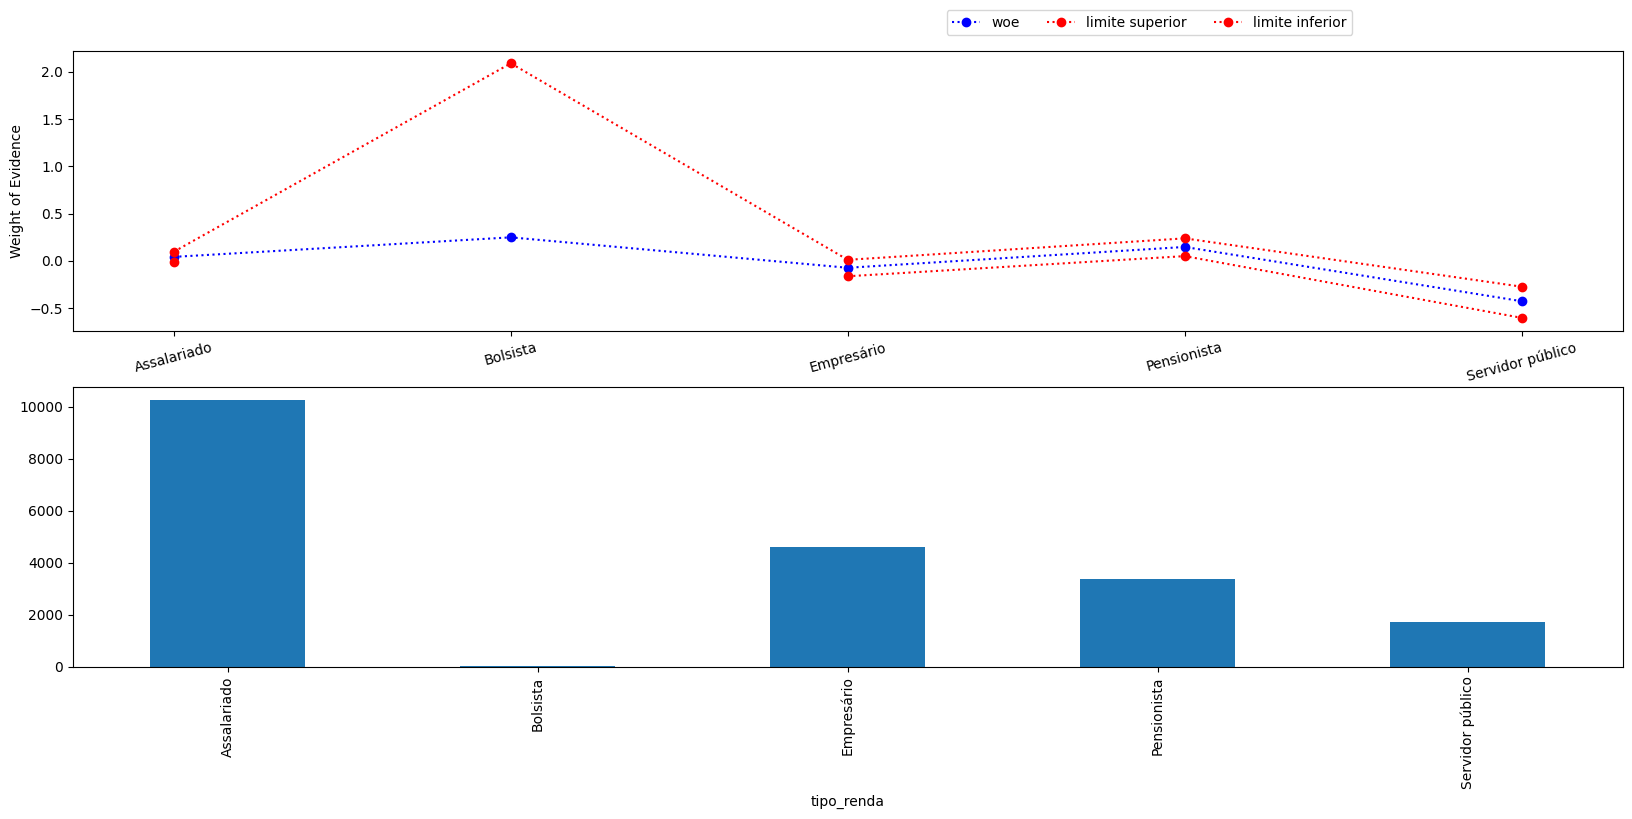

In [29]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,195,42,0.177215,Fundamental,237,0.024804,0.226080,0.128350,-1.535330,-1.230577,-1.915628,0.322324,0.627077,-0.057974
Médio,11548,1869,0.139301,Médio,13417,0.002989,0.145160,0.133441,-1.821109,-1.773074,-1.870868,0.036546,0.084580,-0.013213
Pós graduação,24,3,0.111111,Pós graduação,27,0.060481,0.235432,-0.013210,-2.079442,-1.177889,NaN,-0.221787,0.679766,NaN
Superior completo,4819,663,0.120941,Superior completo,5482,0.004404,0.129574,0.112308,-1.983547,-1.904727,-2.067379,-0.125892,-0.047072,-0.209725
Superior incompleto,679,117,0.146985,Superior incompleto,796,0.012550,0.171621,0.122349,-1.758447,-1.574184,-1.970371,0.099207,0.283471,-0.112717


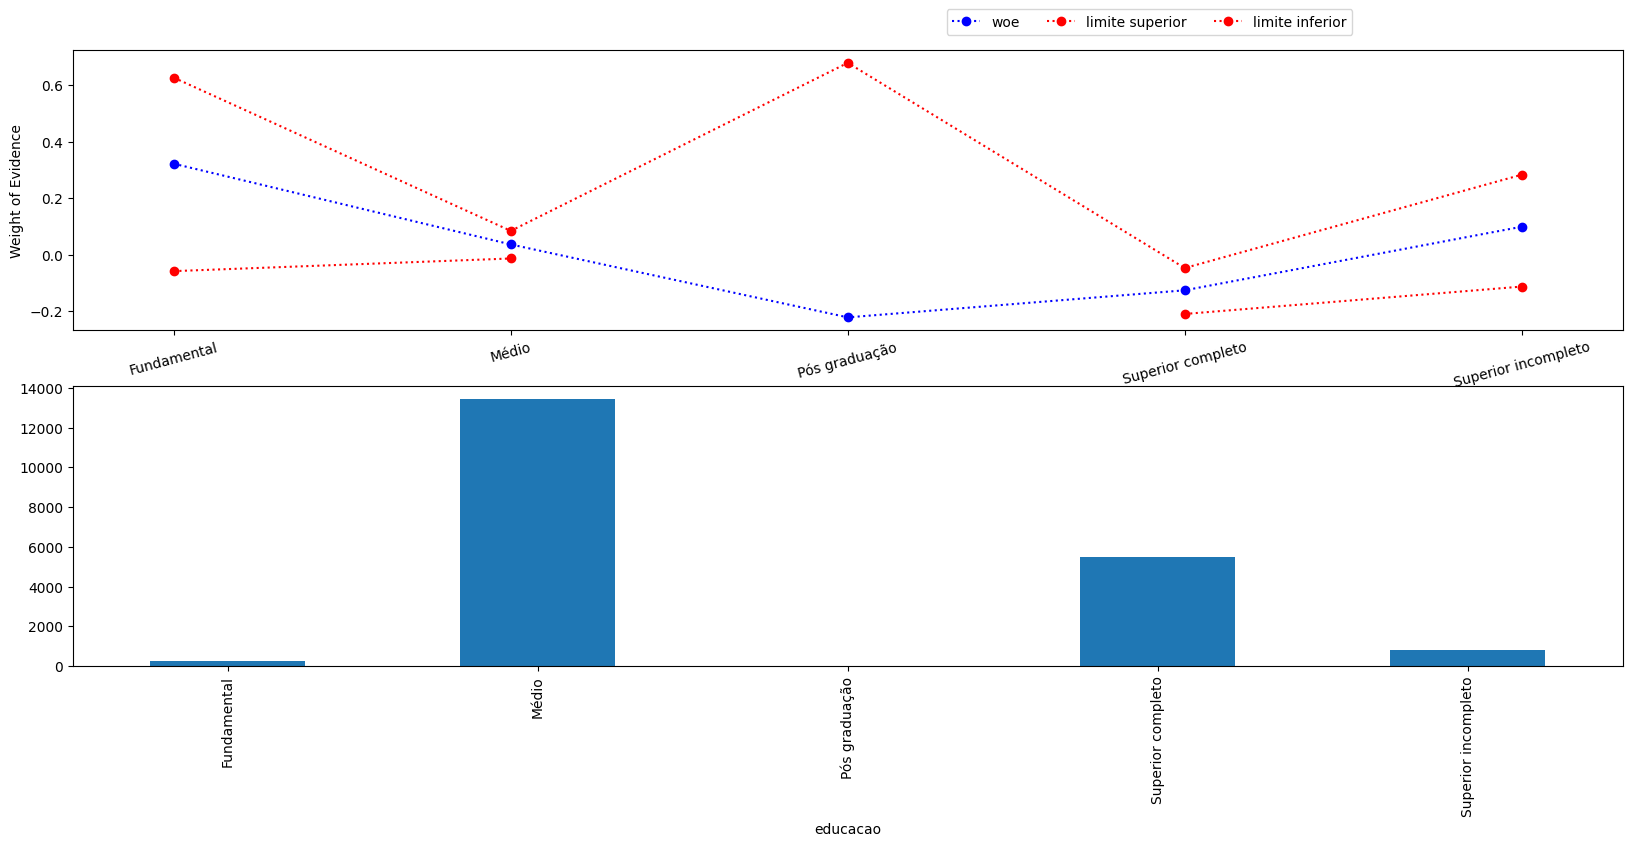

In [30]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,12185,1839,0.131132,Casado,14024,0.002850,0.136719,0.125545,-1.890984,-1.842809,-1.940934,-0.033329,0.014845,-0.083279
Separado,940,162,0.147005,Separado,1102,0.010667,0.167936,0.126075,-1.758284,-1.600328,-1.936116,0.099371,0.257326,-0.078462
Solteiro,2141,358,0.143257,Solteiro,2499,0.007008,0.157000,0.129515,-1.788495,-1.680724,-1.905254,0.069159,0.176930,-0.047599
União,1327,221,0.142765,União,1548,0.008892,0.160206,0.125324,-1.792513,-1.656700,-1.942949,0.065141,0.200955,-0.085295
Viúvo,672,114,0.145038,Viúvo,786,0.012560,0.169694,0.120382,-1.774060,-1.587797,-1.988815,0.083594,0.269857,-0.131161


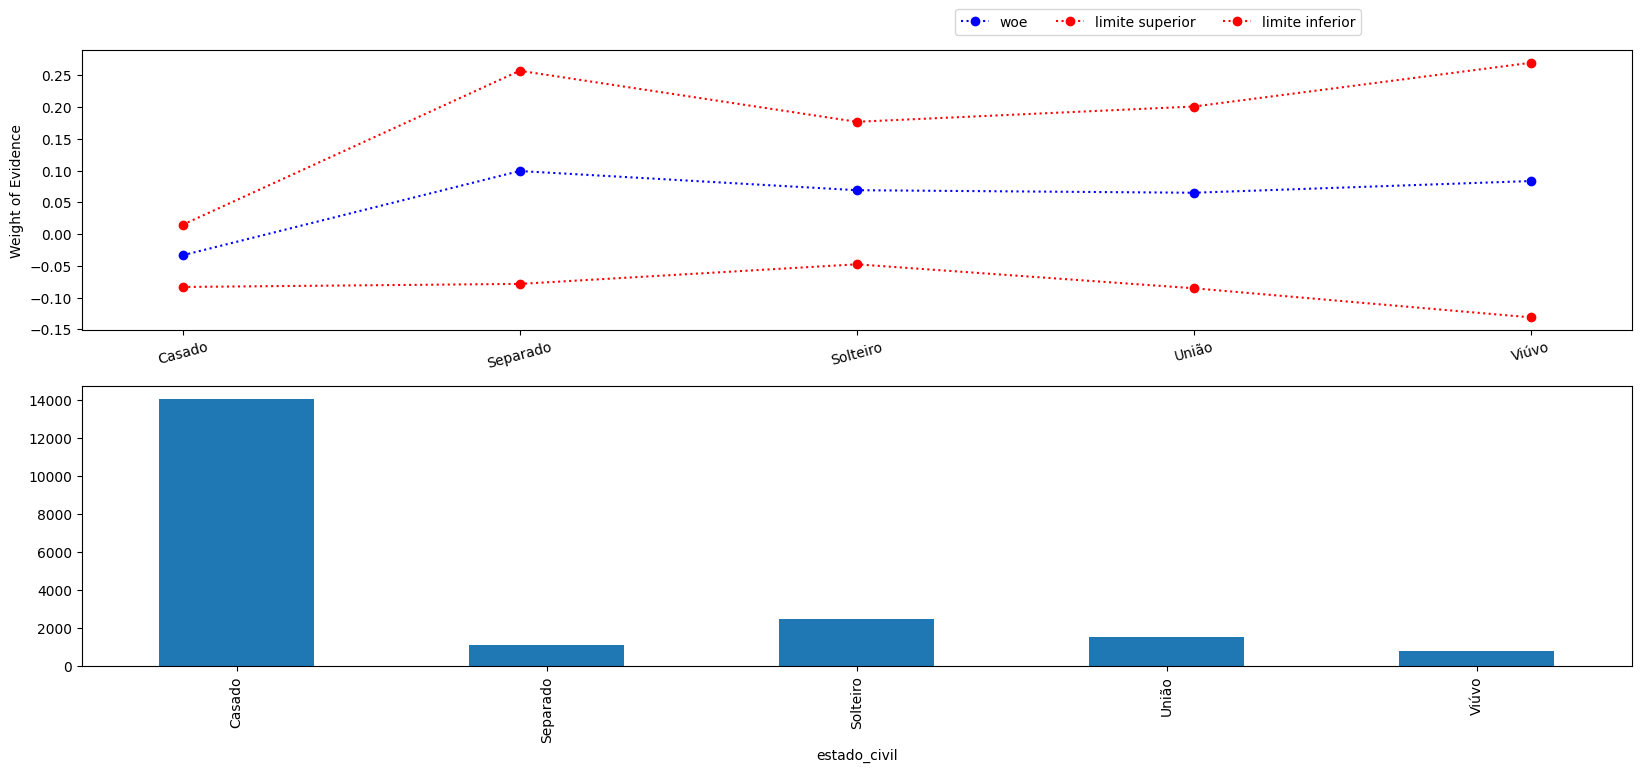

In [31]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\551178251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,230,38,0.141791,Aluguel,268,0.021309,0.183745,0.099837,-1.800493,-1.491177,-2.199038,0.057161,0.366478,-0.341384
Casa,15532,2421,0.134852,Casa,17953,0.002549,0.139849,0.129855,-1.858722,-1.816546,-1.902238,-0.001067,0.041108,-0.044583
Com os pais,764,125,0.140607,Com os pais,889,0.011659,0.163489,0.117726,-1.810254,-1.632493,-2.014146,0.047400,0.225162,-0.156492
Comunitário,78,12,0.133333,Comunitário,90,0.035832,0.204531,0.062135,-1.871802,-1.358211,-2.714290,-0.014148,0.499444,-0.856635
Estúdio,130,17,0.115646,Estúdio,147,0.026377,0.167776,0.063517,-2.034321,-1.601474,-2.690827,-0.176667,0.256180,-0.833173
Governamental,531,81,0.132353,Governamental,612,0.013698,0.159254,0.105452,-1.880313,-1.663788,-2.138066,-0.022659,0.193866,-0.280411


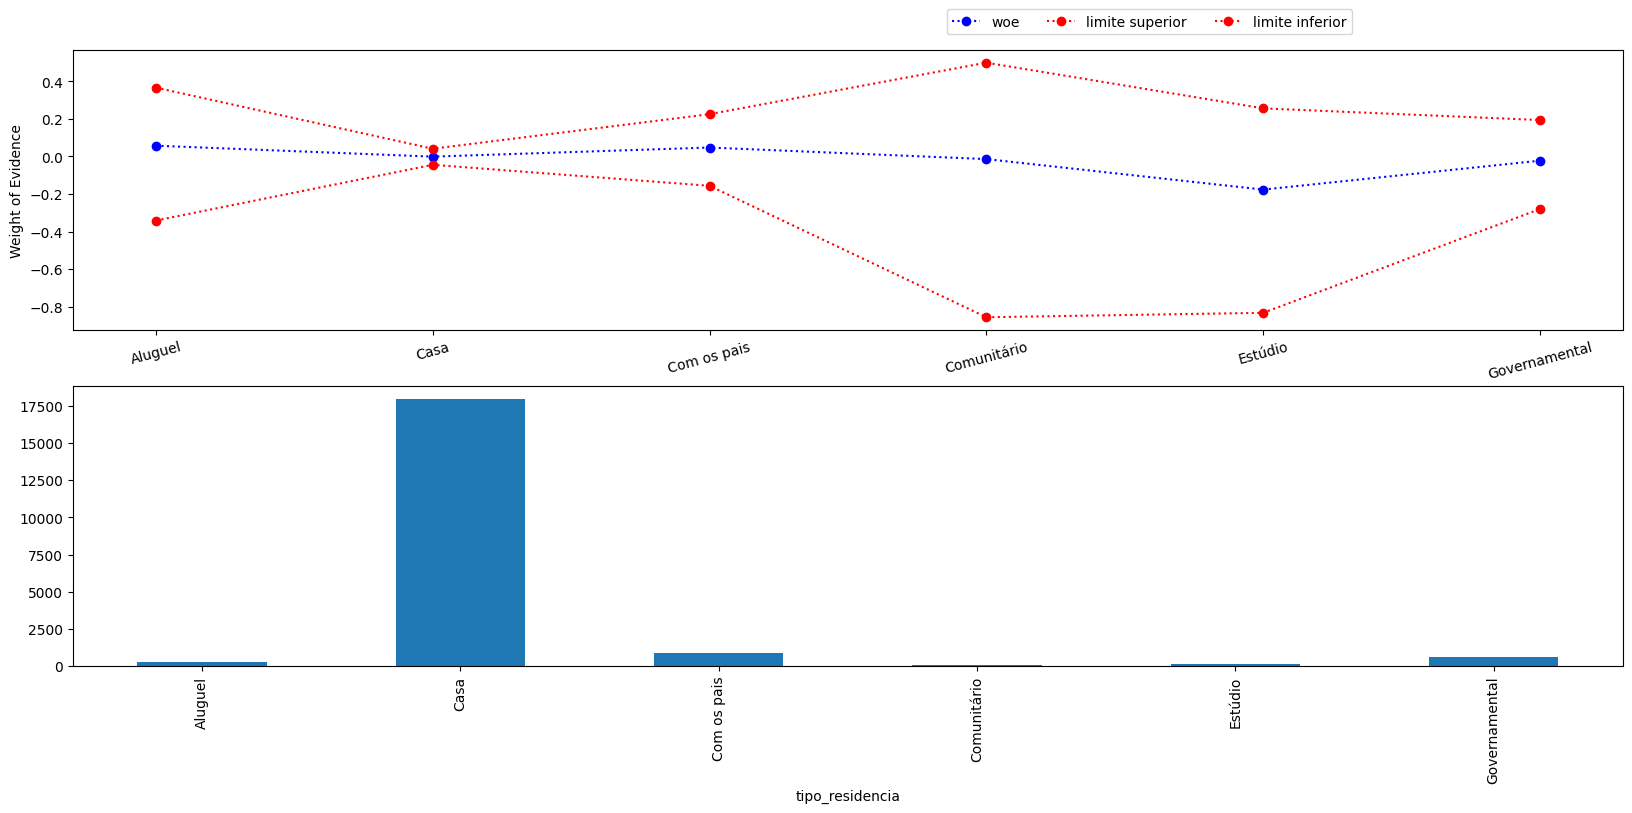

In [32]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

In [33]:
# Função de gráfico e calculos WOE
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, _ = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    _, ax = plt.subplots(2,1, figsize=(20, 8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return None

In [34]:
continuas = df_train.select_dtypes(['int64','float64']).dtypes.index
continuas

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'renda_log', 'bom'],
      dtype='object')

#### Base Teste

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


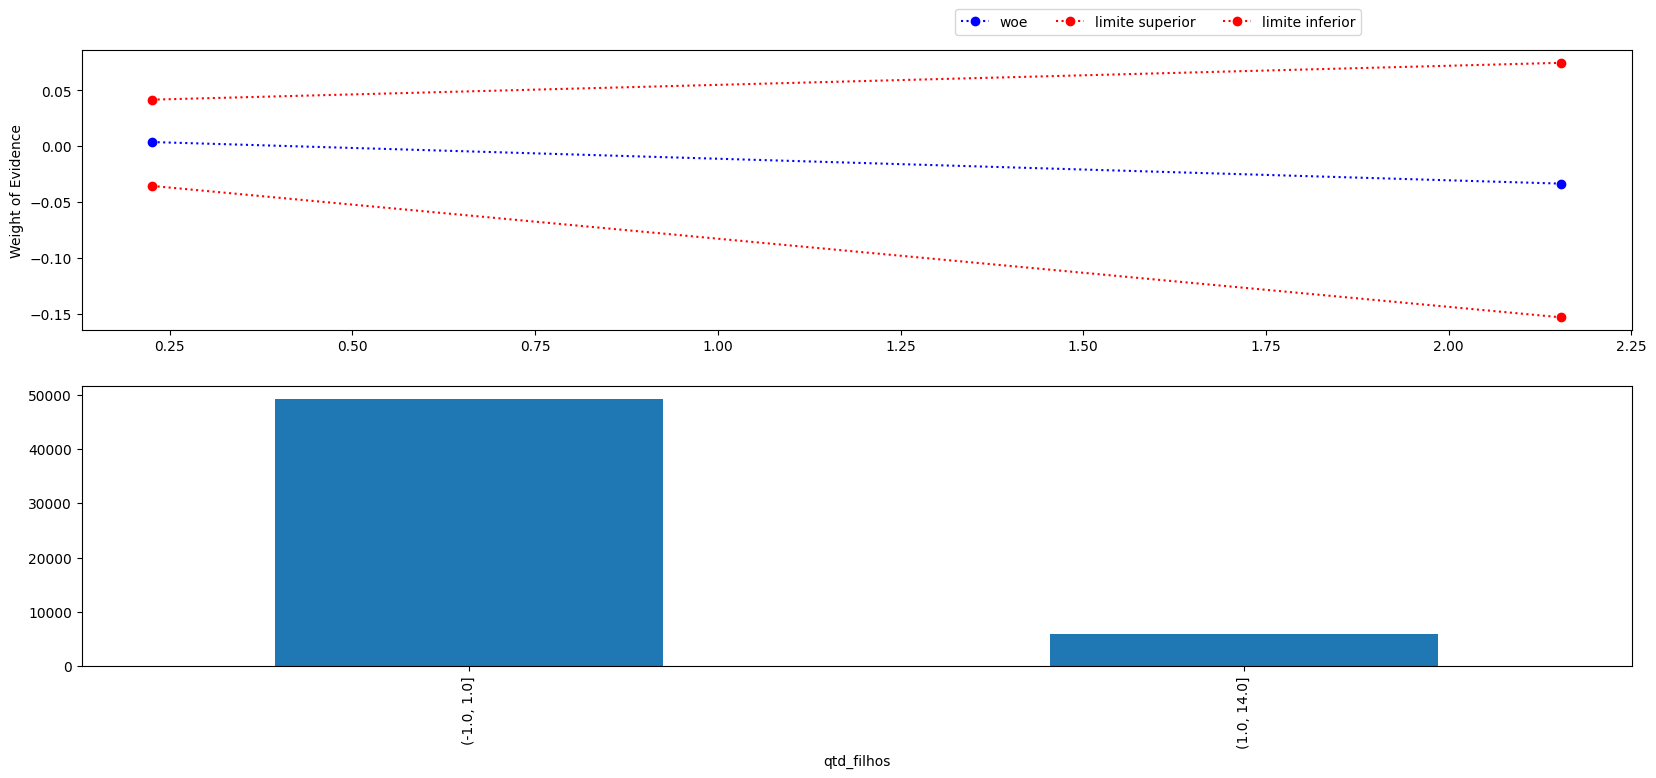

In [35]:
c = 0
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


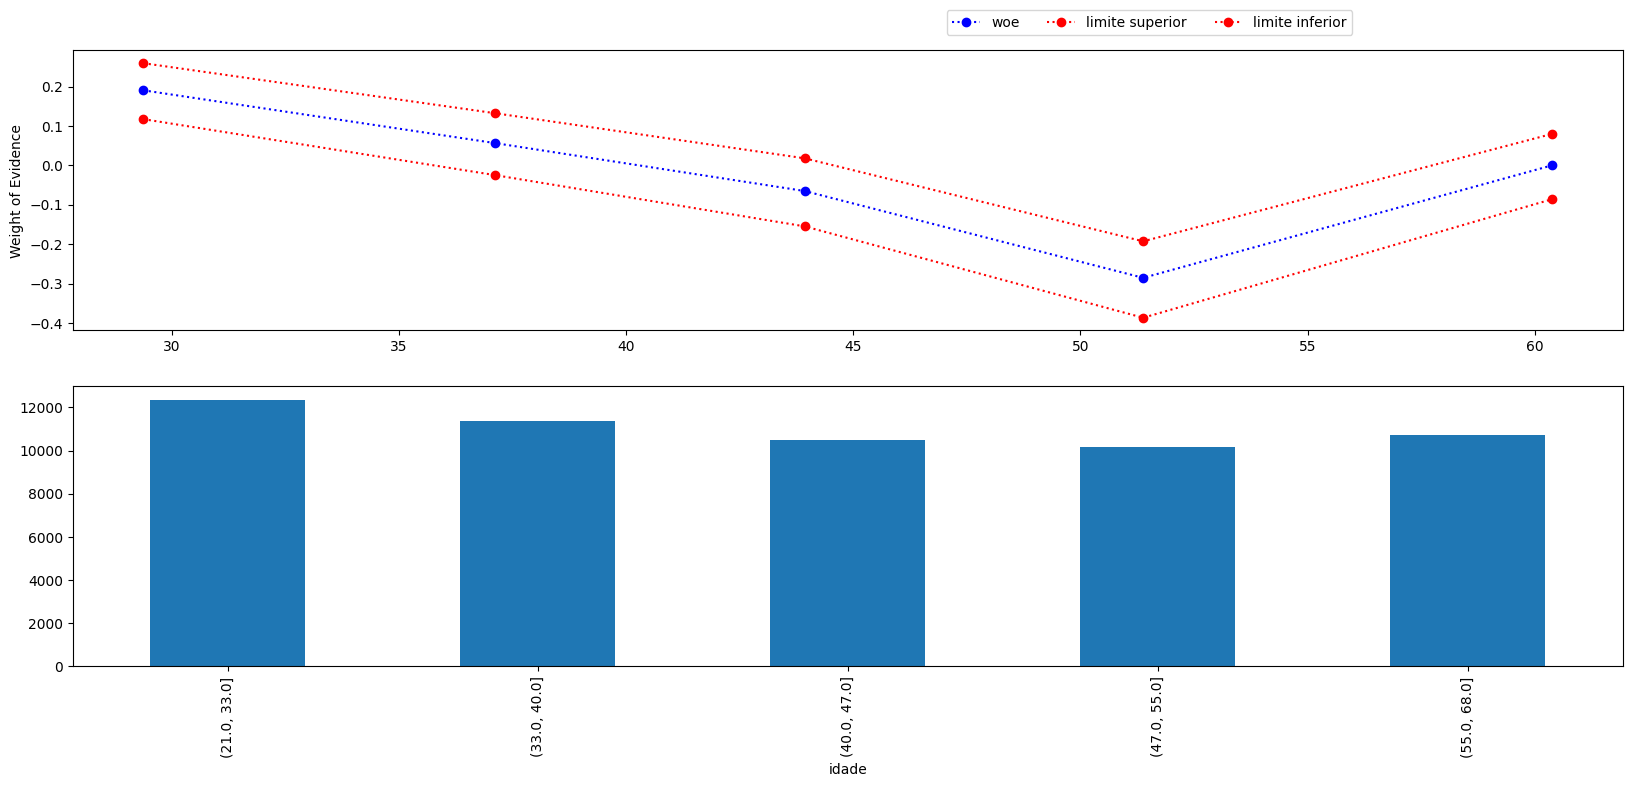

In [36]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


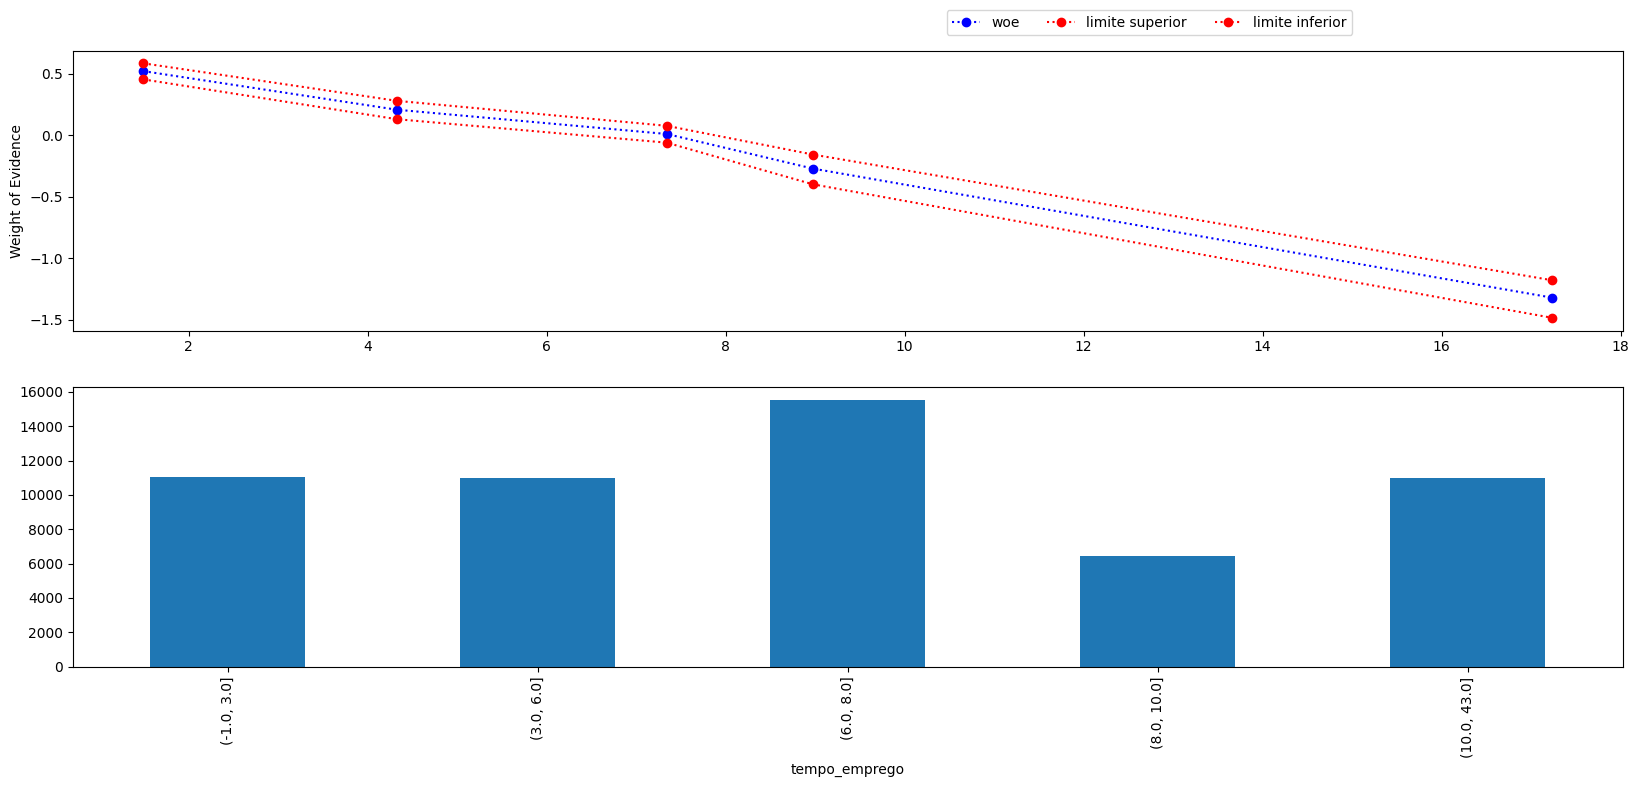

In [37]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


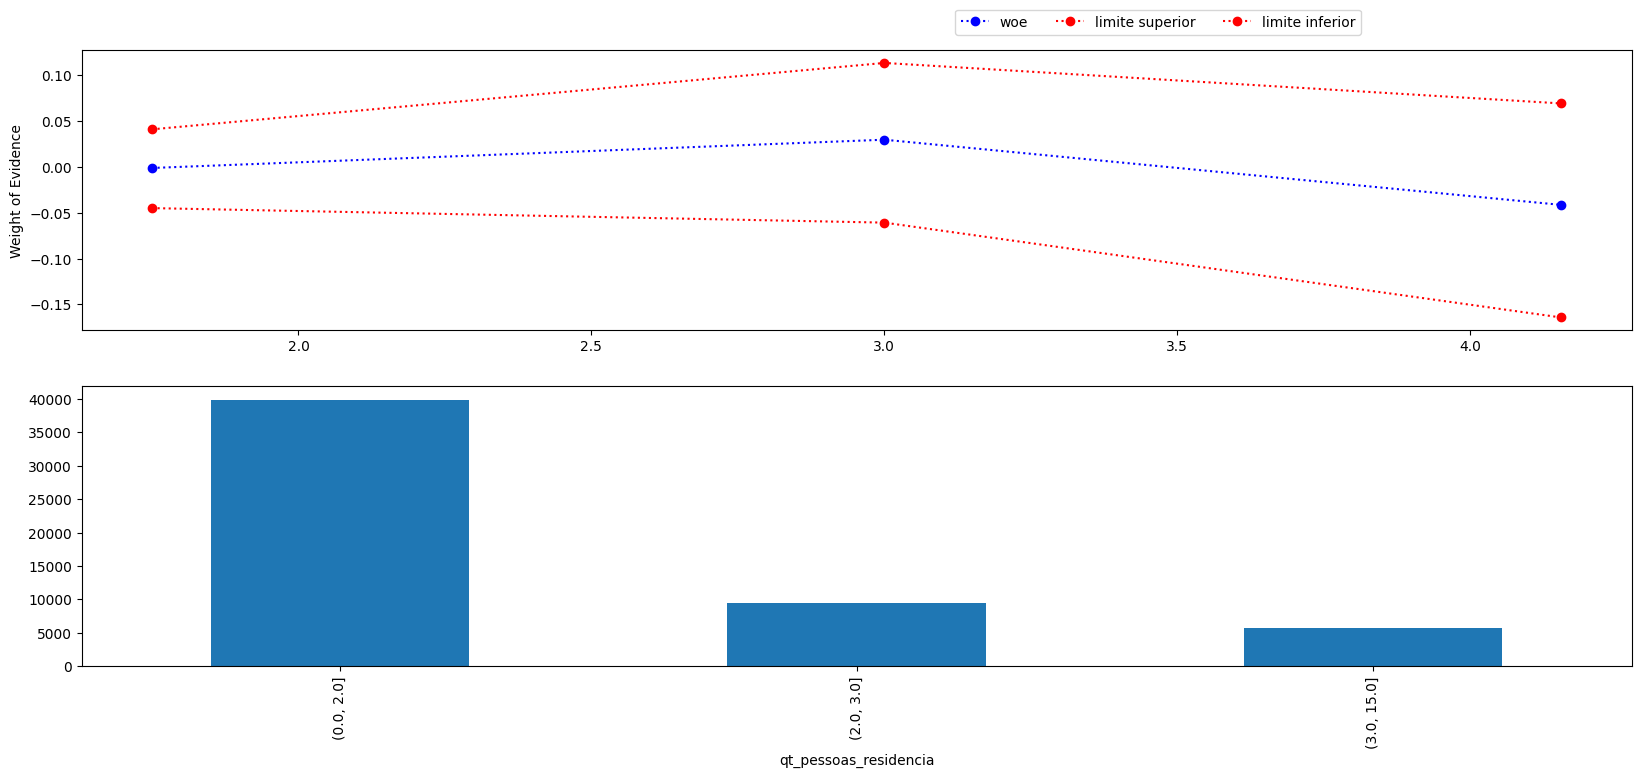

In [38]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


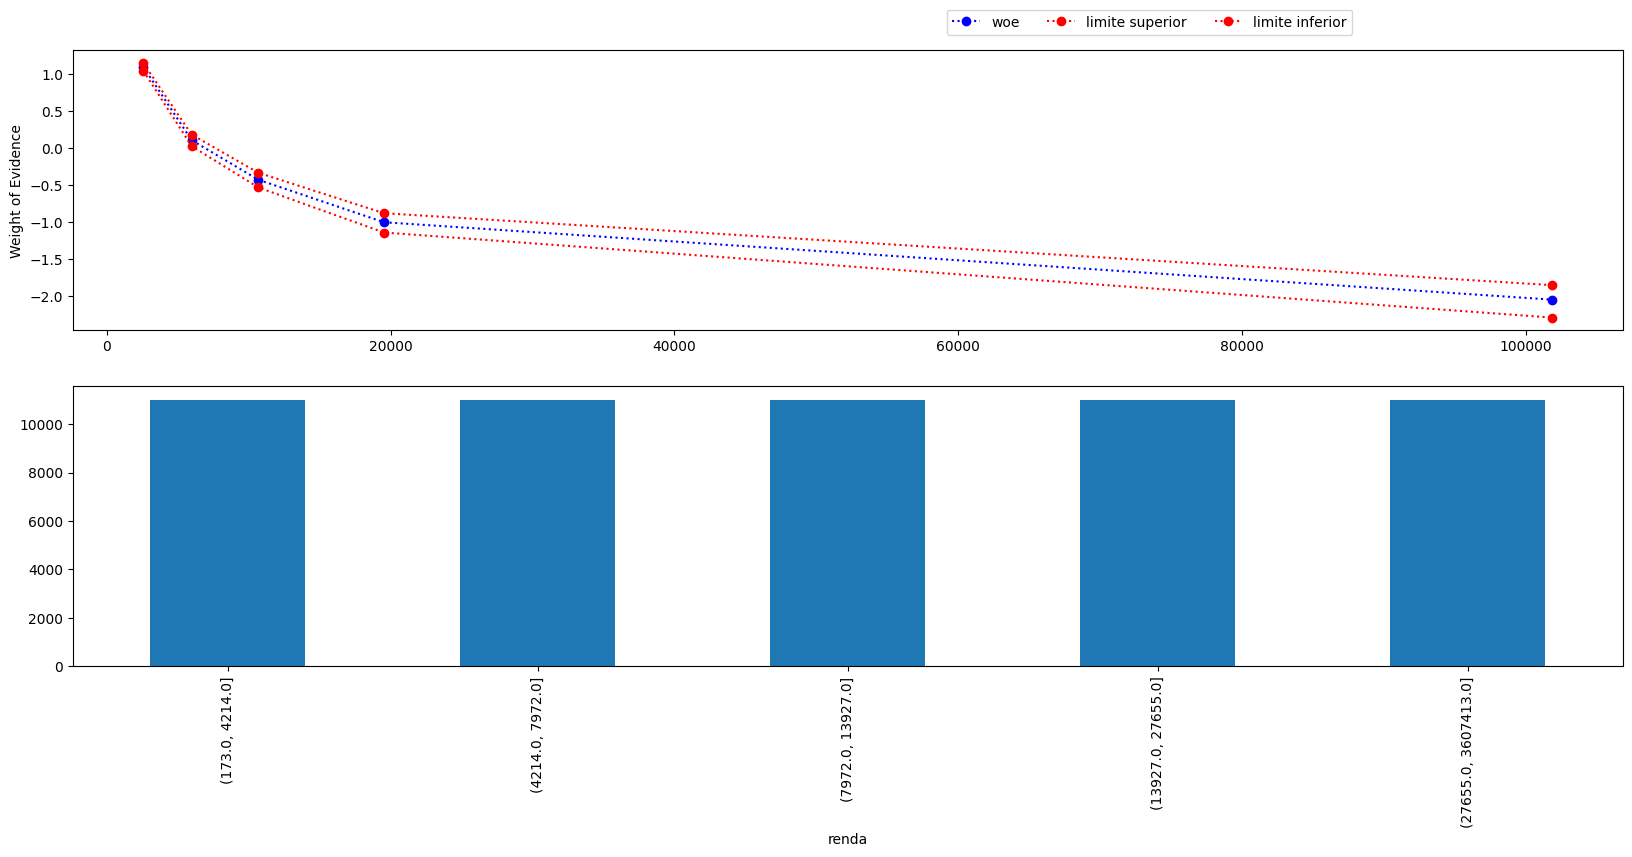

In [39]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


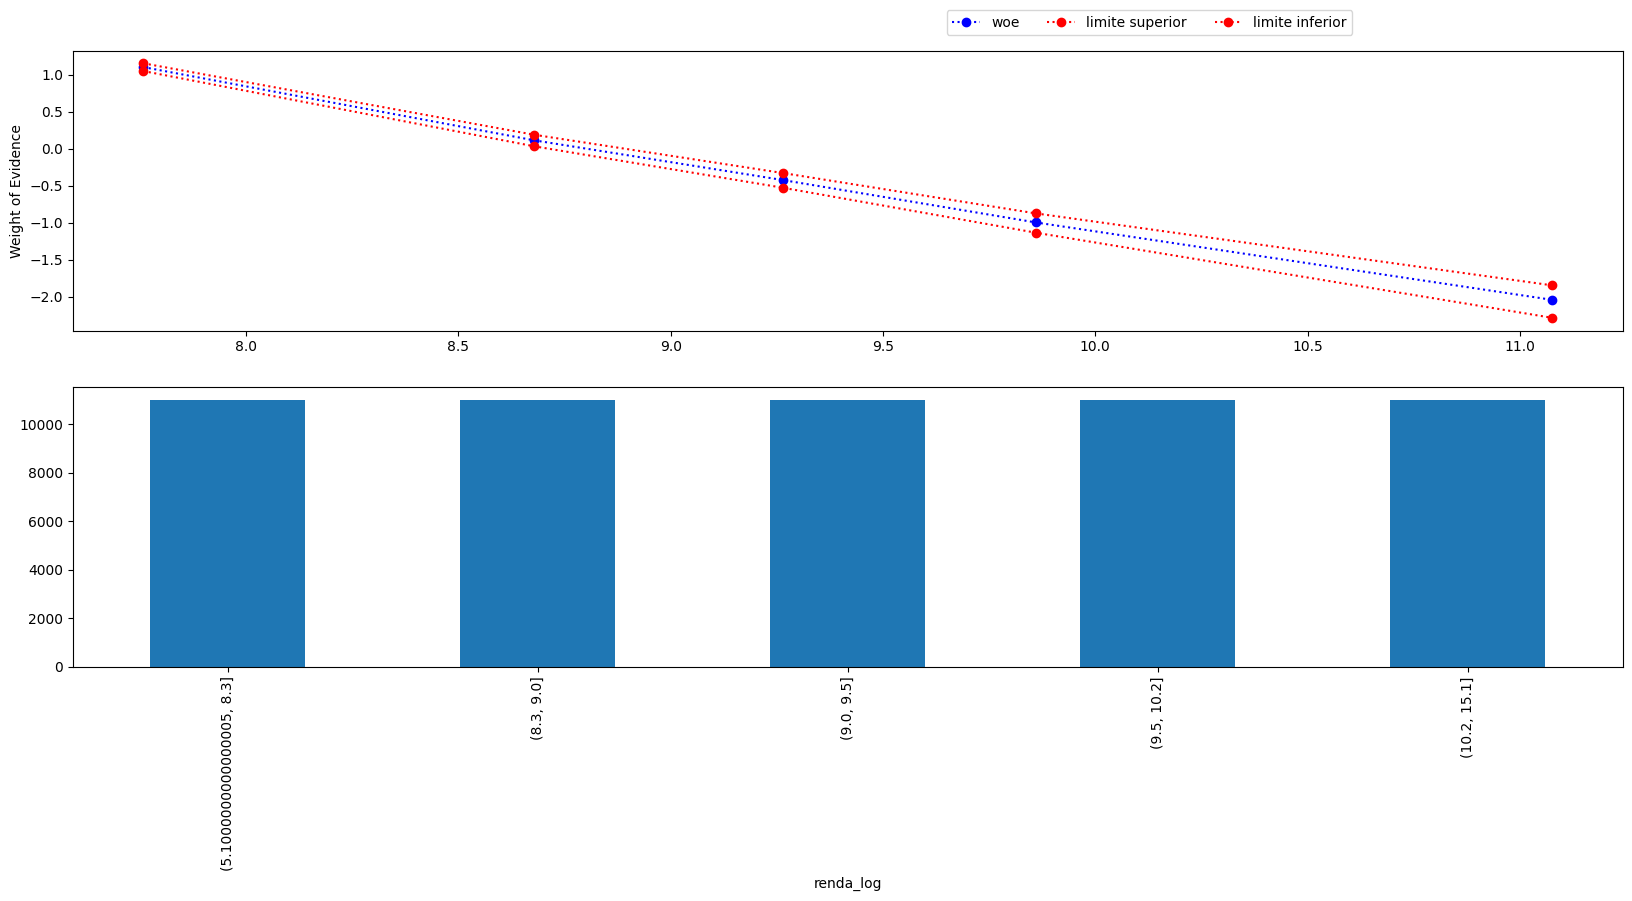

In [40]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

#### Base Validação

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


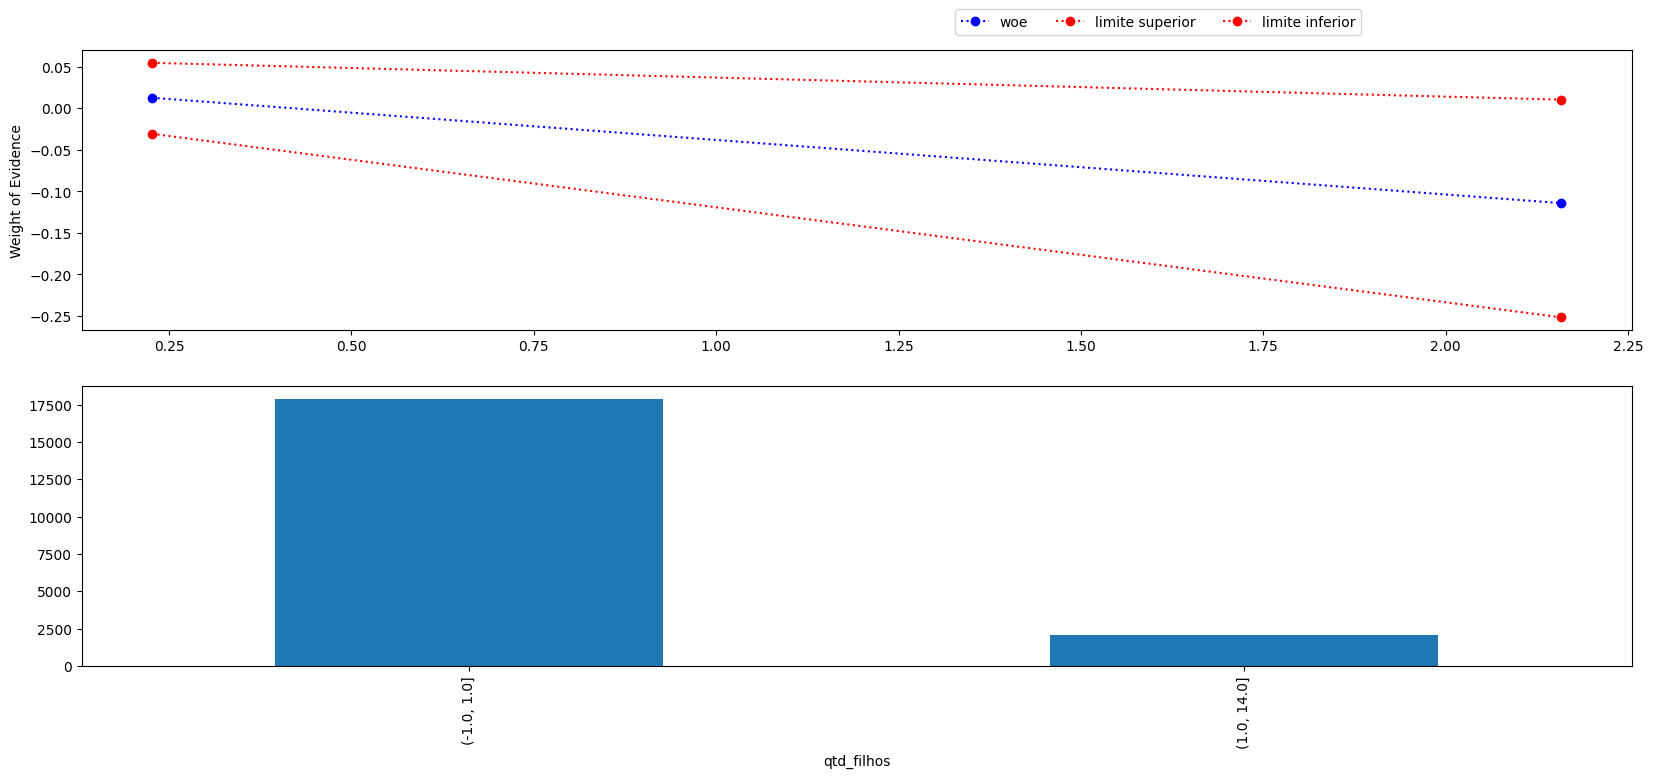

In [41]:
c = 0
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


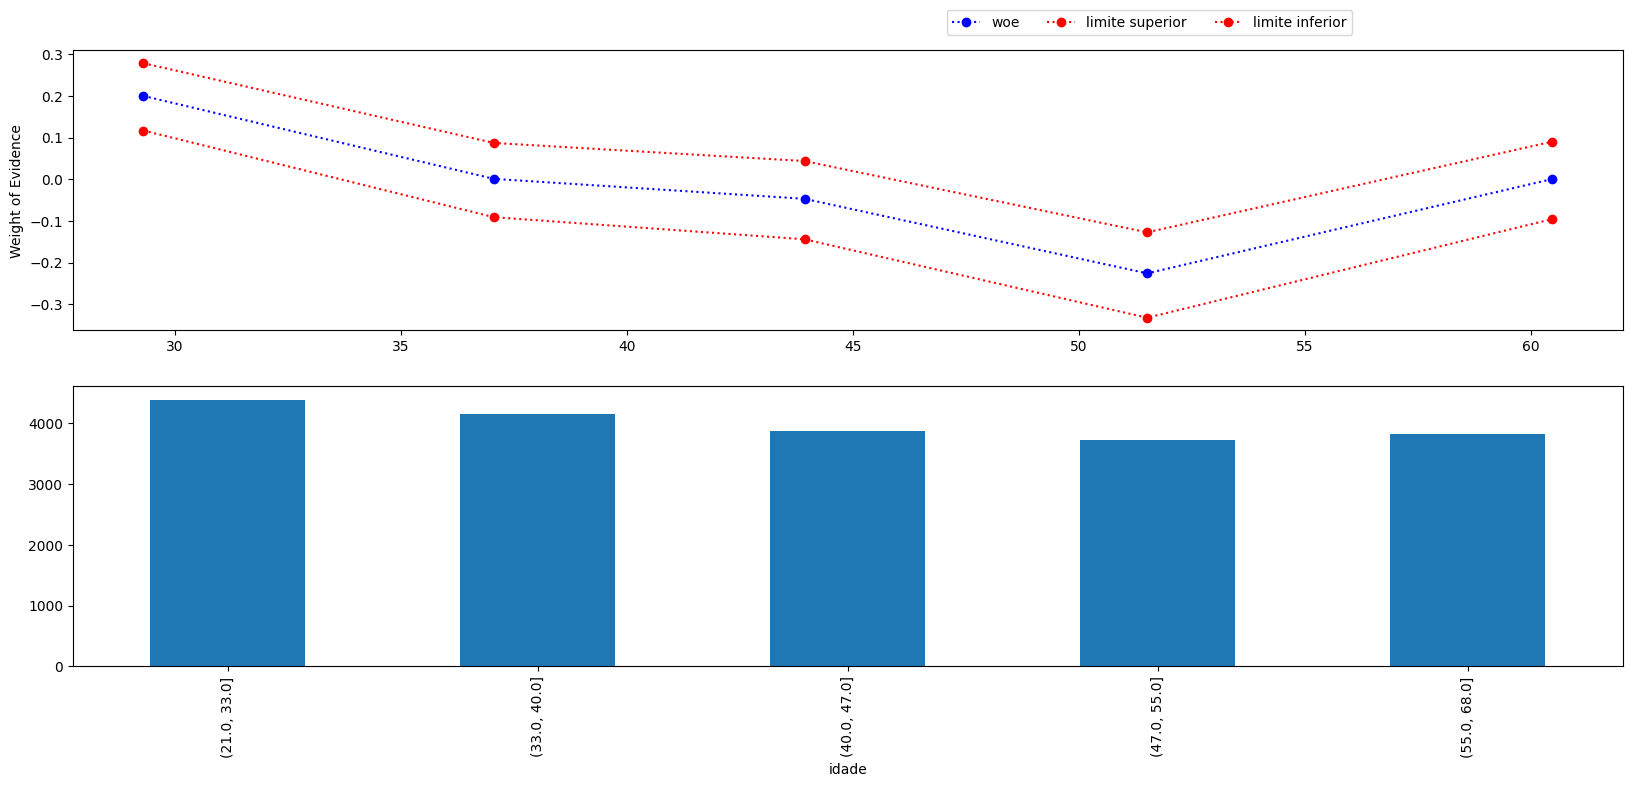

In [42]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


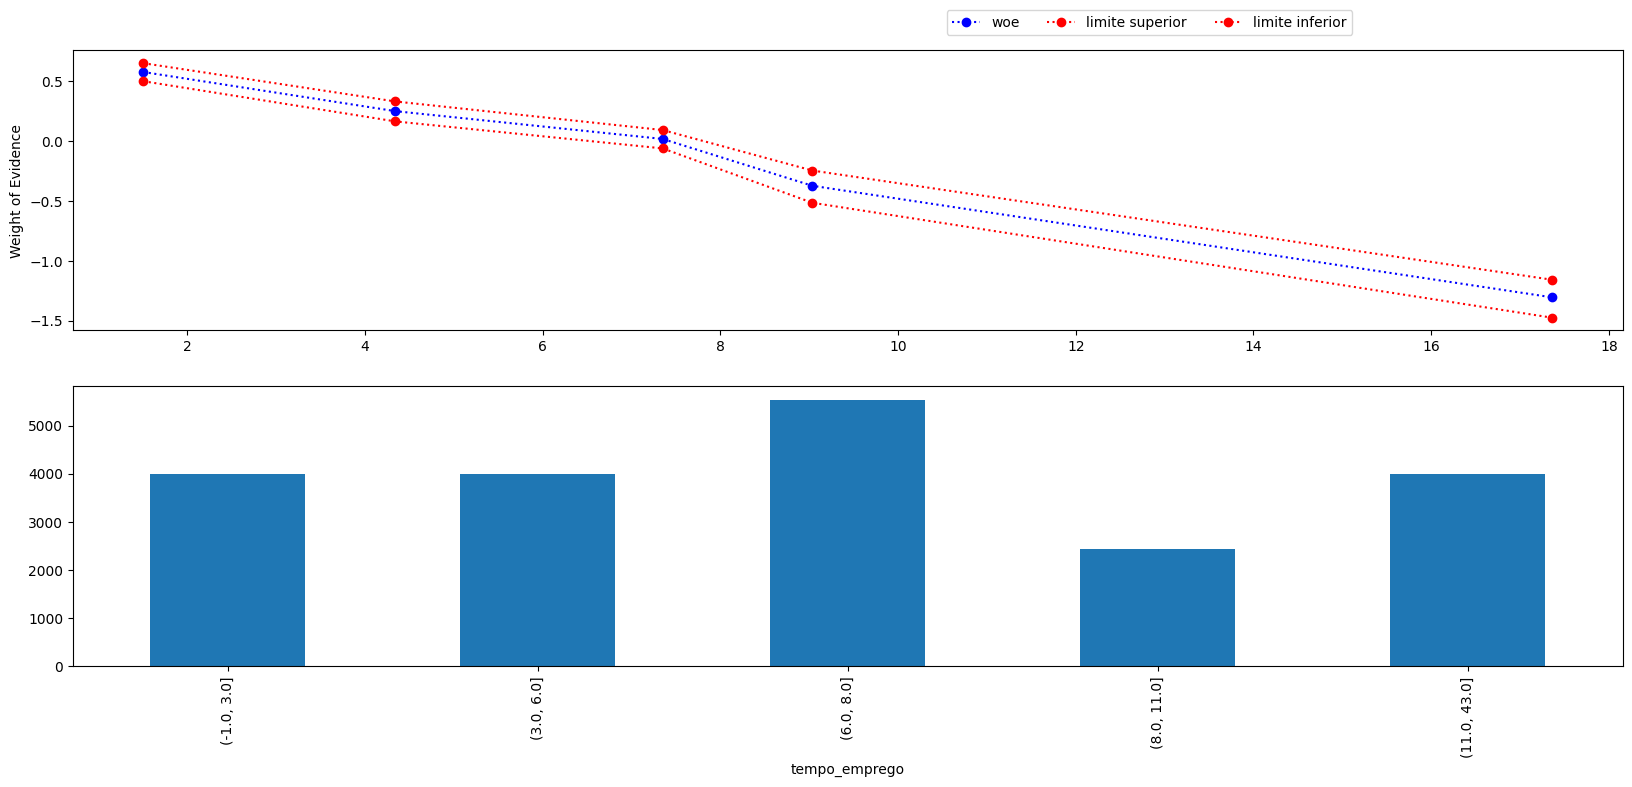

In [43]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


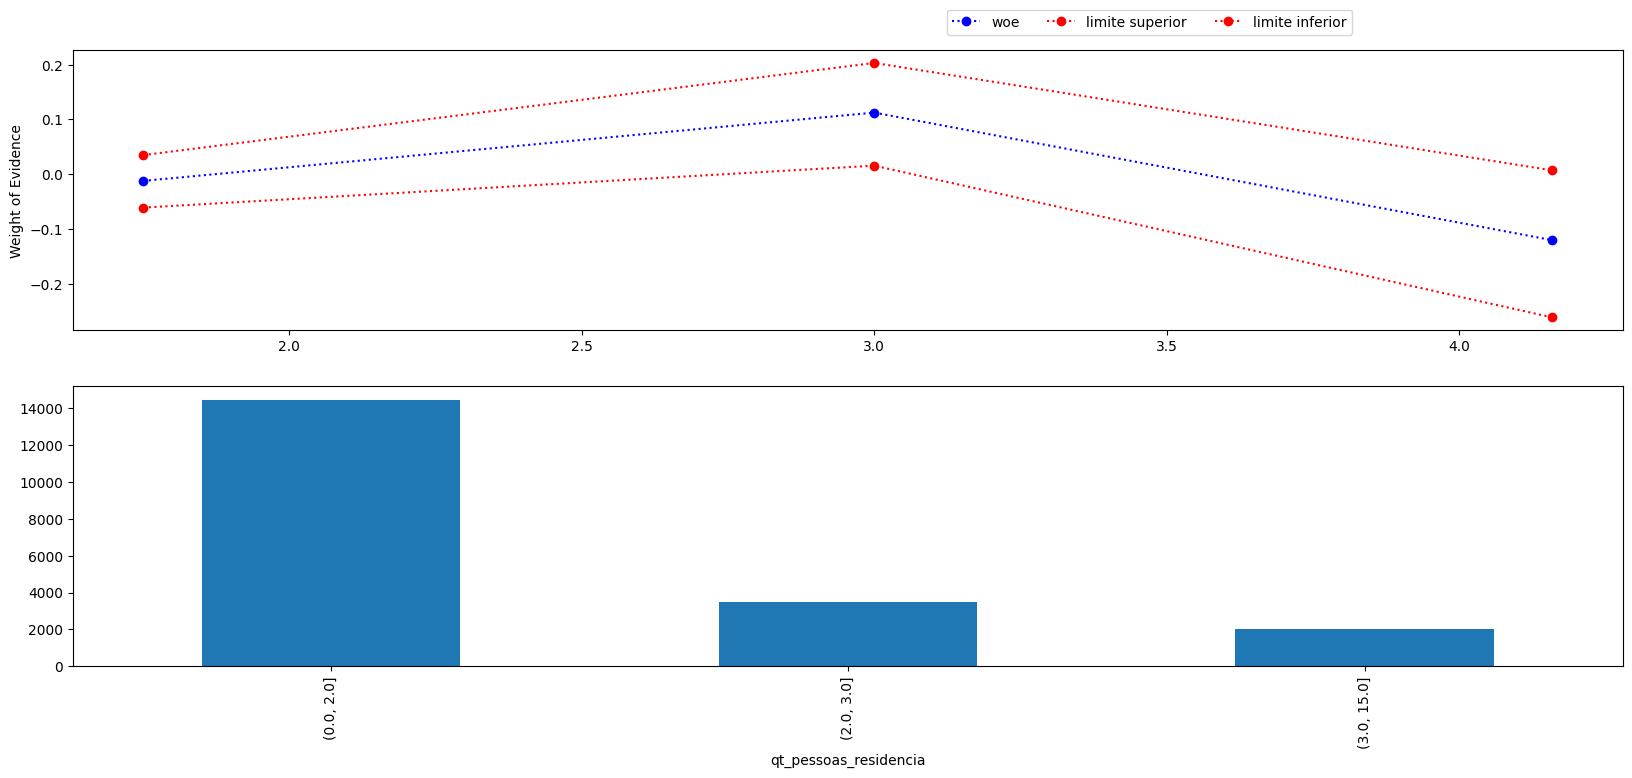

In [44]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


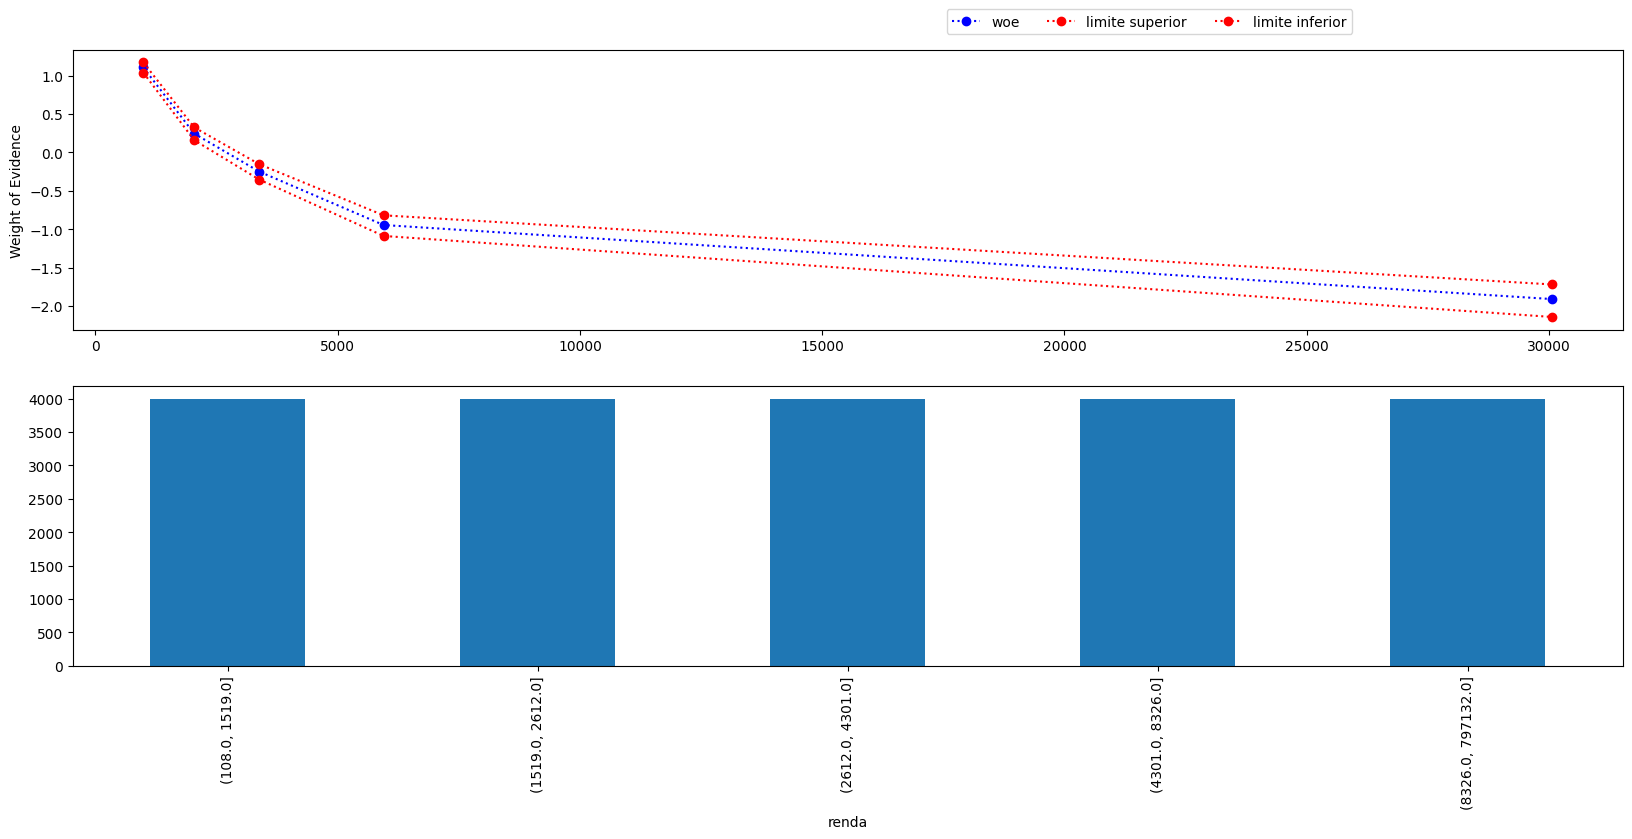

In [45]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\481871678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


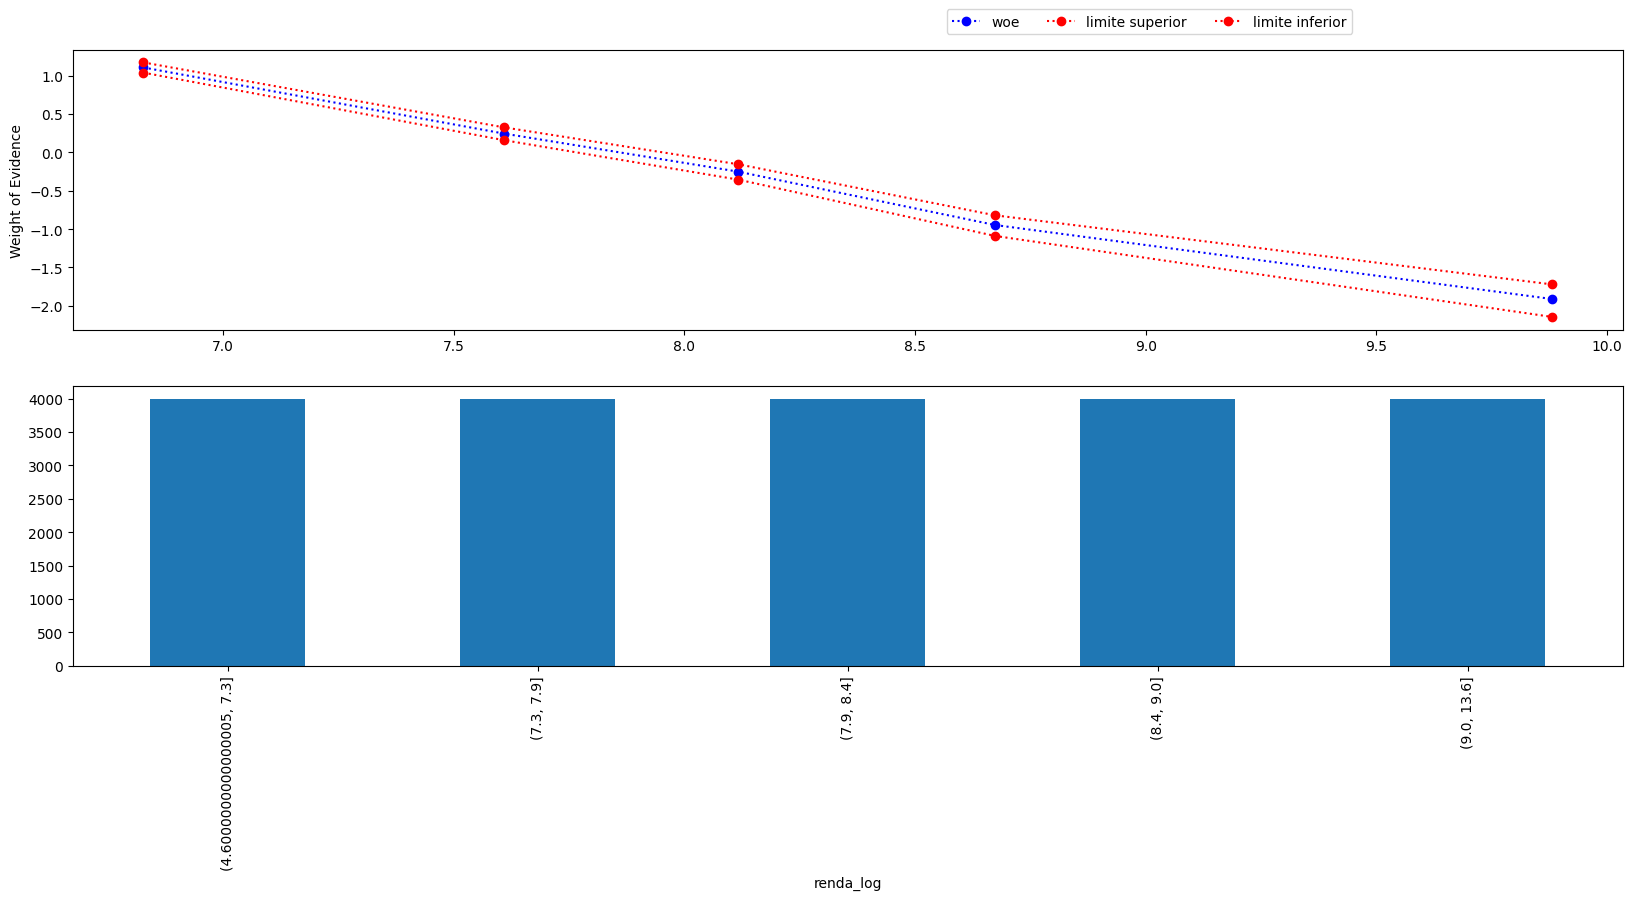

In [46]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

In [47]:
metadados_train = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados_train['nmissing'] = df_train.isna().sum()
metadados_train['valores_unicos'] = df_train.nunique()
metadados_train['papel'] = 'covariavel'
metadados_train.loc['mau','papel'] = 'resposta'
metadados_train

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,11,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


In [48]:
metadados_valid = pd.DataFrame(df_valid.dtypes, columns=['dtype'])
metadados_valid['nmissing'] = df_valid.isna().sum()
metadados_valid['valores_unicos'] = df_valid.nunique()
metadados_valid['papel'] = 'covariavel'
metadados_valid.loc['mau','papel'] = 'resposta'
metadados_valid

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,4,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [49]:
# Define a suavização dos dados na variável lowess
lowess_train = sm.nonparametric.lowess(df_train['renda_log'], df_train['tempo_emprego'], frac=1/9)
lowess_valid = sm.nonparametric.lowess(df_valid['renda_log'], df_valid['tempo_emprego'], frac=1/9)

# Valores de X e Y suavizados
f_train = interp1d(lowess_train[:, 0], lowess_train[:, 1], bounds_error=False)
f_valid = interp1d(lowess_valid[:, 0], lowess_valid[:, 1], bounds_error=False)

df_train.loc[:, 'tempo_emprego_lowess'] = f_train(df_train['tempo_emprego'])
df_valid.loc[:, 'tempo_emprego_lowess'] = f_valid(df_valid['tempo_emprego'])
df_train.head()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\866355704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'tempo_emprego_lowess'] = f_train(df_train['tempo_emprego'])
C:\Users\gfsil\AppData\Local\Temp\ipykernel_35368\866355704.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
124216,2015-03-01,F,N,S,0,Empresário,Superior completo,Casado,Com os pais,26,7.602740,2.0,2475.93,False,7.814371,3,1,9.372790
431058,2015-09-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,51,3.621918,2.0,8613.73,False,9.061113,9,1,8.855980
152335,2015-04-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,48,10.345205,1.0,14616.35,False,9.589896,4,1,9.729248
217358,2015-05-01,F,S,S,0,Assalariado,Médio,Casado,Casa,53,10.663014,2.0,22468.43,False,10.019866,5,1,9.779580
298516,2015-06-01,F,N,S,0,Assalariado,Médio,Casado,Governamental,42,2.109589,2.0,4377.31,False,8.384190,6,1,8.652063


In [50]:
df_valid.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
688163,2016-02-01,M,N,S,1,Empresário,Superior completo,Casado,Casa,36,11.613699,3.0,12324.26,False,9.419325,2,1,8.758416
603270,2016-01-01,M,S,N,0,Pensionista,Médio,Casado,Casa,51,7.748784,2.0,1161.29,True,7.057287,1,0,7.960442
692450,2016-02-01,M,S,S,0,Empresário,Superior completo,Casado,Estúdio,37,12.019178,2.0,7946.57,False,8.980496,2,1,8.810724
717143,2016-03-01,F,S,S,0,Servidor público,Superior completo,Casado,Casa,53,2.961644,2.0,2535.27,False,7.838055,3,1,7.693337
660245,2016-02-01,M,N,S,0,Empresário,Médio,Casado,Casa,41,1.632877,2.0,10595.49,False,9.268184,2,1,7.456149


In [51]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_train).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     8361.
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        08:40:21   Log-Likelihood:                -72514.
No. Observations:               55041   AIC:                         1.450e+05
Df Residuals:                   55035   BIC:                         1.451e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       0.0986      0.046      2.143      0.032       0.008       0.189
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -0.1898      0.011    -17.229      0.000      -0.211      -0.168
C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]            -0.3062      0.160     -1.913      0.056      -0.620       0.008
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]          -0.0246      0.012     -1.974      0.048      -0.049      -0.000
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]    -0.0557      0.017     -3.373      0.001      -0.088      -0.023
tempo_emprego_lowess                                            1.0023      0.005    199.468      0.000       0.992       1.012
==============================================================================
Omnibus:                      128.969   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.637
Skew:                          -0.102   Prob(JB):                     5.23e-28
Kurtosis:                       2.884   Cond. No.                         391.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Sumário dos dados de treinamento do modelo
reg_redc_summary_frame = reg_redc.get_influence().summary_frame()
reg_redc_summary_frame.head()

,dfb_Intercept,"dfb_C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Empresário]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]",dfb_tempo_emprego_lowess,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
124216,0.001300,0.000256,0.000034,-0.010398,0.000313,-0.001328,4.458870e-05,-1.830664,0.000080,-0.016356,-1.830703,-0.016357
431058,0.000258,0.000051,0.000007,0.000735,0.000062,-0.000263,2.100800e-07,0.122557,0.000084,0.001123,0.122556,0.001123
152335,0.000144,-0.000198,0.000004,0.000016,0.000035,-0.000147,3.943190e-08,-0.077999,0.000039,-0.000486,-0.077998,-0.000486
217358,-0.000726,0.000848,-0.000019,-0.000083,-0.000175,0.000742,7.804581e-07,0.342050,0.000040,0.002164,0.342048,0.002164
298516,-0.000874,-0.000802,-0.000023,-0.000099,-0.000210,0.000892,4.112507e-07,-0.217512,0.000052,-0.001571,-0.217510,-0.001571


In [53]:
# Análise dos valores com maior peso no modelo
remov_index_max = reg_redc_summary_frame['hat_diag'].max()
remov_index = reg_redc_summary_frame[reg_redc_summary_frame['hat_diag'] == remov_index_max]['hat_diag'].index
remov_index

Index([129686, 158522,  13927,  73678,   1666,  66247, 499911, 522279,  60089,
       260512, 323217, 511813, 380527, 455928,  81531,  56432, 131236, 141609,
       290323, 158405,  18132, 132581, 272935, 523824, 352793, 239677, 144066,
       349854, 494644, 466482, 134329, 328112],
      dtype='int64')

In [54]:
# Remoção dos valores ouliers com maior peso do modelo
df_train_outliers = df_train.drop(remov_index)
df_train_outliers.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
124216,2015-03-01,F,N,S,0,Empresário,Superior completo,Casado,Com os pais,26,7.602740,2.0,2475.93,False,7.814371,3,1,9.372790
431058,2015-09-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,51,3.621918,2.0,8613.73,False,9.061113,9,1,8.855980
152335,2015-04-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,48,10.345205,1.0,14616.35,False,9.589896,4,1,9.729248
217358,2015-05-01,F,S,S,0,Assalariado,Médio,Casado,Casa,53,10.663014,2.0,22468.43,False,10.019866,5,1,9.779580
298516,2015-06-01,F,N,S,0,Assalariado,Médio,Casado,Governamental,42,2.109589,2.0,4377.31,False,8.384190,6,1,8.652063


In [55]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_train_outliers).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:14:57   Log-Likelihood:                -72472.
No. Observations:               55009   AIC:                         1.450e+05
Df Residuals:                   55004   BIC:                         1.450e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       0.0986      0.046      2.143      0.032       0.008       0.189
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -0.1898      0.011    -17.229      0.000      -0.211      -0.168
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]          -0.0246      0.012     -1.974      0.048      -0.049      -0.000
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]    -0.0557      0.017     -3.373      0.001      -0.088      -0.023
tempo_emprego_lowess                                            1.0023      0.005    199.467      0.000       0.992       1.012
==============================================================================
Omnibus:                      128.764   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.462
Skew:                          -0.102   Prob(JB):                     5.70e-28
Kurtosis:                       2.884   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# Salvando em disco o modelo e os registros de treinamento
dump(reg_redc_summary_frame, "./data/reg_redc_summary_frame")
dump(reg_redc, "./data/reg_redc")

['./data/reg_redc']

## Conclussão

- Trate valores missings e outliers
<br>R.: Valores missing foram substituídos pela média.

- Trate 'zeros estruturais'
<br>R.: Não foram encontrados zeros estruturais.

- Faça agrupamentos de categorias conforme vimos em aula
<br>R.: Não foi necessário agrupar categorias.

- Proponha uma equação preditiva para 'mau'
<br>R,: Equação mais eficiente usa tempo de emprego suavizado e tipo de renda com cazela de Pnesionista

- Caso hajam categorias não significantes, justifique
<br>R.: Categorias não significativas foram resolvidas com a retirada dos outliers.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

Treino

In [57]:
# Obtenção da predição na base de treino
df_train_outliers['y_pred'] = reg_redc.predict(df_train_outliers)
y_pred = df_train_outliers['y_pred']
y_true = df_train_outliers['renda_log']

In [58]:
# KS
ks_2samp(y_true, y_pred)

KstestResult(statistic=np.float64(0.1999854569252304), pvalue=np.float64(0.0), statistic_location=np.float64(8.34854729503823), statistic_sign=np.int8(1))

In [59]:
# Gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(y_pred)

np.float64(0.04234021639450943)

Validação

In [60]:
# Removendo uma das categorias da base de validação, que não está presente no teste
df_valid = df_valid[~(df_valid['tipo_renda'] == "Bolsista")]
df_valid['tipo_renda'].value_counts()

tipo_renda
Assalariado         10257
Empresário           4613
Pensionista          3372
Servidor público     1711
Name: count, dtype: int64

In [61]:
# Obtenção da predição na base de treino
df_valid['y_pred'] = reg_redc.predict(df_valid)
y_pred = df_valid['y_pred']
y_true = df_valid['renda_log']

In [62]:
# KS
ks_2samp(y_true, y_pred)

KstestResult(statistic=np.float64(0.17456021650879566), pvalue=np.float64(2.5324497143387008e-266), statistic_location=np.float64(7.2401621202134265), statistic_sign=np.int8(1))

In [63]:
# Gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(y_pred)

np.float64(0.04846720914712806)

### Conclusão
- Não foram observadas diferenças significativas entre a base de treino e a de validação
  
|Base|KS|Gini|
|-|-|-|
|Treino|0.204|0.042|
|Validação|0.17|0.049|

- Não é possível obter a acurácia de um modelo de predição para variável contínua

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

In [64]:
# Carregando base
df = pd.read_feather('./../36_modulo/data/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [65]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [66]:
# Obtendo amostra da base para a modelagem, devido ao grande número de instâncias
df_copy = df.sample(frac=.1).copy()

# Inserindo dados faltantes com média em tempo de emprego
df_copy.fillna({"tempo_emprego": np.mean(df_copy['tempo_emprego'])}, inplace=True)
df_copy.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [67]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_train).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     8361.
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:15:52   Log-Likelihood:                -72514.
No. Observations:               55041   AIC:                         1.450e+05
Df Residuals:                   55035   BIC:                         1.451e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       0.0986      0.046      2.143      0.032       0.008       0.189
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]         -0.1898      0.011    -17.229      0.000      -0.211      -0.168
C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]            -0.3062      0.160     -1.913      0.056      -0.620       0.008
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]          -0.0246      0.012     -1.974      0.048      -0.049      -0.000
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]    -0.0557      0.017     -3.373      0.001      -0.088      -0.023
tempo_emprego_lowess                                            1.0023      0.005    199.468      0.000       0.992       1.012
==============================================================================
Omnibus:                      128.969   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.637
Skew:                          -0.102   Prob(JB):                     5.23e-28
Kurtosis:                       2.884   Cond. No.                         391.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
# Sumário dos dados de treinamento do modelo
reg_redc_summary_frame = reg_redc.get_influence().summary_frame()
remov_index_max = reg_redc_summary_frame['hat_diag'].max()
remov_index = reg_redc_summary_frame[reg_redc_summary_frame['hat_diag'] == remov_index_max]['hat_diag'].index
df_train_outliers = df_train.drop(remov_index)
df_train_outliers.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
124216,2015-03-01,F,N,S,0,Empresário,Superior completo,Casado,Com os pais,26,7.602740,2.0,2475.93,False,7.814371,3,1,9.372790
431058,2015-09-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,51,3.621918,2.0,8613.73,False,9.061113,9,1,8.855980
152335,2015-04-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,48,10.345205,1.0,14616.35,False,9.589896,4,1,9.729248
217358,2015-05-01,F,S,S,0,Assalariado,Médio,Casado,Casa,53,10.663014,2.0,22468.43,False,10.019866,5,1,9.779580
298516,2015-06-01,F,N,S,0,Assalariado,Médio,Casado,Governamental,42,2.109589,2.0,4377.31,False,8.384190,6,1,8.652063


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [69]:
# Define a suavização dos dados na variável lowess
lowess_train = sm.nonparametric.lowess(df_train_outliers['renda_log'], df_train_outliers['tempo_emprego'], frac=1/9)
lowess_valid = sm.nonparametric.lowess(df_valid['renda_log'], df_valid['tempo_emprego'], frac=1/9)

# Valores de X e Y suavizados
f_train = interp1d(lowess_train[:, 0], lowess_train[:, 1], bounds_error=False)
f_valid = interp1d(lowess_valid[:, 0], lowess_valid[:, 1], bounds_error=False)

df_train_outliers.loc[:, 'tempo_emprego_lowess'] = f_train(df_train_outliers['tempo_emprego'])
df_valid.loc[:, 'tempo_emprego_lowess'] = f_valid(df_valid['tempo_emprego'])
df_train_outliers.head()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
124216,2015-03-01,F,N,S,0,Empresário,Superior completo,Casado,Com os pais,26,7.602740,2.0,2475.93,False,7.814371,3,1,9.372772
431058,2015-09-01,M,S,N,0,Empresário,Superior completo,Casado,Casa,51,3.621918,2.0,8613.73,False,9.061113,9,1,8.856027
152335,2015-04-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,48,10.345205,1.0,14616.35,False,9.589896,4,1,9.730913
217358,2015-05-01,F,S,S,0,Assalariado,Médio,Casado,Casa,53,10.663014,2.0,22468.43,False,10.019866,5,1,9.780937
298516,2015-06-01,F,N,S,0,Assalariado,Médio,Casado,Governamental,42,2.109589,2.0,4377.31,False,8.384190,6,1,8.652056


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [70]:
selecionar = [
    "sexo",
    "posse_de_veiculo",
    "posse_de_imovel",
    "tipo_renda",
    "educacao",
    "estado_civil",
    "tipo_residencia",
]
selecionar

['sexo',
 'posse_de_veiculo',
 'posse_de_imovel',
 'tipo_renda',
 'educacao',
 'estado_civil',
 'tipo_residencia']

In [71]:
df_train_outliers_dummies = pd.get_dummies(df_train_outliers[selecionar], drop_first=True)
df_train_outliers_dummies.head()

,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Médio,educacao_Pós graduação,educacao_Superior completo,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
124216,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
431058,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
152335,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False
217358,False,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
298516,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [72]:
pca = pd.DataFrame(PCA(n_components=5).fit_transform(df_train_outliers_dummies))
pca['tempo_emprego_lowess'] = df_train_outliers['tempo_emprego_lowess'].values
pca['renda_log'] = df_train_outliers['renda_log'].values
pca.head()

,0,1,2,3,4,tempo_emprego_lowess,renda_log
0,-0.900228,-0.667113,-0.240177,0.691439,0.167372,9.372772,7.814371
1,-1.345484,0.658180,-0.426946,0.350656,-0.055760,8.856027,9.061113
2,-0.734665,-0.891769,0.174245,-0.048049,0.342636,9.730913,9.589896
3,0.292627,0.285457,0.449236,-0.052735,-0.580042,9.780937,10.019866
4,0.564124,-0.241647,-0.118631,0.010328,0.135854,8.652056,8.384190


### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [73]:
# Teste de função própria para o Pipeline

def soma_teste_func(a: list) -> int|float:
    resultado_soma = sum(a)
    valor_maximo = max(a)
    return (resultado_soma, valor_maximo)

def divide_teste_func(b: list) -> float:
    return b[0]/b[1]

soma_teste_trans = FunctionTransformer(soma_teste_func)
divide_teste_trans = FunctionTransformer(divide_teste_func)

teste_pipe = Pipeline(
    steps=[
        ("soma_teste", soma_teste_trans),
        ("divide_teste", divide_teste_trans)
    ]
)

teste_pipe.transform((2, 3, 4))

2.25

In [89]:
def substitui_nulos(valores_substituir: list) -> list:
    # Substituir nulos
    df_copy_sub = valores_substituir[0]
    variavel_sub = "tempo_emprego"
    df_copy_sub.fillna({variavel_sub: np.mean(df_copy_sub[variavel_sub])}, inplace=True),
    retorno = (
        df_copy_sub,
        valores_substituir[1]
    )
    return retorno

def remove_outliers(valores_remove: list) -> pd.DataFrame:
    # Remoção de outliers
    df_train_val = valores_remove[0]
    reg_redc_summary_frame = valores_remove[1]
    remov_index_max = reg_redc_summary_frame['hat_diag'].max()
    remov_index = reg_redc_summary_frame[reg_redc_summary_frame['hat_diag'] == remov_index_max]['hat_diag'].index
    df_train_outliers = df_train_val.drop(remov_index)
    return df_train_outliers

def cria_dummies(df_train_outliers: pd.DataFrame) -> list:
    # Criação de Dummie
    selecionar = [
        "sexo",
        "posse_de_veiculo",
        "posse_de_imovel",
        "tipo_renda",
        "educacao",
        "estado_civil",
        "tipo_residencia",
    ]
    df_train_outliers_dummies = pd.get_dummies(df_train_outliers[selecionar], drop_first=True)
    return (df_train_outliers_dummies, df_train_outliers)

def cria_pca(valores_pca: list):
    # PCA
    df_train_outliers_dummies = valores_pca[0]
    df_train_outliers = valores_pca[1]
    pca = pd.DataFrame(PCA(n_components=5).fit_transform(df_train_outliers_dummies))
    pca['tempo_emprego_lowess'] = df_train_outliers['tempo_emprego_lowess'].values
    pca['renda_log'] = df_train_outliers['renda_log'].values
    pca.rename(
            columns={
                0: "zero",
                1: "one",
                2: "two",
                3: "three",
                4: "four",
            },
            inplace=True    
    )
    return pca


enviar_transform = (
    df_train,
    reg_redc_summary_frame
)

In [90]:
rotina_pipe = Pipeline(
    steps=[
        ("substitui_nulos", FunctionTransformer(substitui_nulos)),
        ("remove_outliers", FunctionTransformer(remove_outliers)),
        ("cria_dummies", FunctionTransformer(cria_dummies)),
        ("cria_pca", FunctionTransformer(cria_pca))
    ]
)

    rotina_pipe.steps

[('substitui_nulos',
  FunctionTransformer(func=<function substitui_nulos at 0x0000026C5CE65CF0>)),
 ('remove_outliers',
  FunctionTransformer(func=<function remove_outliers at 0x0000026C5CE65E10>)),
 ('cria_dummies',
  FunctionTransformer(func=<function cria_dummies at 0x0000026C64C9DE10>)),
 ('cria_pca',
  FunctionTransformer(func=<function cria_pca at 0x0000026C64C9DCF0>))]

In [91]:
df_final = rotina_pipe.transform(enviar_transform)
df_final.head()

,zero,one,two,three,four,tempo_emprego_lowess,renda_log
0,-0.900228,-0.667113,-0.240177,0.691439,0.167372,9.372790,7.814371
1,-1.345484,0.658180,-0.426946,0.350656,-0.055760,8.855980,9.061113
2,-0.734665,-0.891769,0.174245,-0.048049,0.342636,9.729248,9.589896
3,0.292627,0.285457,0.449236,-0.052735,-0.580042,9.779580,10.019866
4,0.564124,-0.241647,-0.118631,0.010328,0.135854,8.652063,8.384190


In [92]:
dump(df_final, "./data/df_final")

['./data/df_final']

In [93]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~
            one +
            two +
            zero +
            three +
            four +
            tempo_emprego_lowess
'''
reg_redc_pca = smf.ols(formula=formula, data=df_final).fit()

reg_redc_pca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     7168.
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:00:29   Log-Likelihood:                -72132.
No. Observations:               55009   AIC:                         1.443e+05
Df Residuals:                   55002   BIC:                         1.443e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0601      0.045      1.327      0.184      -0.029       0.149
one                     -0.0190      0.007     -2.798      0.005      -0.032      -0.006
two                      0.2303      0.008     28.908      0.000       0.215       0.246
zero                    -0.0882      0.006    -14.841      0.000      -0.100      -0.077
three                    0.0583      0.009      6.667      0.000       0.041       0.075
four                     0.0796      0.010      7.916      0.000       0.060       0.099
tempo_emprego_lowess     0.9948      0.005    205.428      0.000       0.985       1.004
==============================================================================
Omnibus:                      132.566   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.694
Skew:                          -0.102   Prob(JB):                     1.13e-28
Kurtosis:                       2.879   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
dump(df_final, "./data/reg_redc_pca")

['./data/reg_redc_pca']

# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [46]:
# Carregando base
df = load("./data/df")
df_copy = df.sample(frac=.01).copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 260206 to 463260
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               7500 non-null   datetime64[ns]
 1   index                  7500 non-null   int64         
 2   sexo                   7500 non-null   object        
 3   posse_de_veiculo       7500 non-null   object        
 4   posse_de_imovel        7500 non-null   object        
 5   qtd_filhos             7500 non-null   int64         
 6   tipo_renda             7500 non-null   object        
 7   educacao               7500 non-null   object        
 8   estado_civil           7500 non-null   object        
 9   tipo_residencia        7500 non-null   object        
 10  idade                  7500 non-null   int64         
 11  tempo_emprego          6193 non-null   float64       
 12  qt_pessoas_residencia  7500 non-null   float64       
 13  r

In [47]:
df_copy.qtd_filhos = df_copy.qtd_filhos.astype(float)

# Instanciando variável com a base de validação
df_valid = df_copy[df_copy['data_ref'] >= '2015-12-01']

# Instanciando variável com a base de teste
df_train = df_copy[df_copy['data_ref'] < '2015-12-01']
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1990 entries, 600037 to 571377
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               1990 non-null   datetime64[ns]
 1   index                  1990 non-null   int64         
 2   sexo                   1990 non-null   object        
 3   posse_de_veiculo       1990 non-null   object        
 4   posse_de_imovel        1990 non-null   object        
 5   qtd_filhos             1990 non-null   float64       
 6   tipo_renda             1990 non-null   object        
 7   educacao               1990 non-null   object        
 8   estado_civil           1990 non-null   object        
 9   tipo_residencia        1990 non-null   object        
 10  idade                  1990 non-null   int64         
 11  tempo_emprego          1633 non-null   float64       
 12  qt_pessoas_residencia  1990 non-null   float64       
 13  r

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5510 entries, 260206 to 463260
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               5510 non-null   datetime64[ns]
 1   index                  5510 non-null   int64         
 2   sexo                   5510 non-null   object        
 3   posse_de_veiculo       5510 non-null   object        
 4   posse_de_imovel        5510 non-null   object        
 5   qtd_filhos             5510 non-null   float64       
 6   tipo_renda             5510 non-null   object        
 7   educacao               5510 non-null   object        
 8   estado_civil           5510 non-null   object        
 9   tipo_residencia        5510 non-null   object        
 10  idade                  5510 non-null   int64         
 11  tempo_emprego          4560 non-null   float64       
 12  qt_pessoas_residencia  5510 non-null   float64       
 13  r

In [49]:
exp_clf101 = setup(data=df_train, target='mau', session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(5510, 15)"
4,Transformed data shape,"(5510, 34)"
5,Transformed train set shape,"(3856, 34)"
6,Transformed test set shape,"(1654, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [50]:
#ordenando a tabela por AUC
best_model = compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9258,0.7681,0.1870,0.2832,0.2130,0.1829,0.1921,0.1990
gbc,Gradient Boosting Classifier,0.9383,0.7612,0.0563,0.3995,0.0948,0.0824,0.1259,0.9110
lr,Logistic Regression,0.9398,0.7560,0.0000,0.0000,0.0000,0.0000,0.0000,1.1150
ada,Ada Boost Classifier,0.9375,0.7422,0.0261,0.2083,0.0459,0.0368,0.0582,0.3400
lightgbm,Light Gradient Boosting Machine,0.9341,0.7367,0.0737,0.2850,0.1147,0.0944,0.1182,0.4220
xgboost,Extreme Gradient Boosting,0.9310,0.7095,0.0779,0.2775,0.1204,0.0954,0.1178,0.4570
rf,Random Forest Classifier,0.9375,0.7018,0.0259,0.2000,0.0454,0.0363,0.0571,0.5520
nb,Naive Bayes,0.6631,0.6996,0.5732,0.1009,0.1710,0.0767,0.1222,0.1530
lda,Linear Discriminant Analysis,0.9398,0.6429,0.0000,0.0000,0.0000,0.0000,0.0000,0.1600
ridge,Ridge Classifier,0.9398,0.6427,0.0000,0.0000,0.0000,0.0000,0.0000,0.2530


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [51]:
best_model

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [53]:
lightgbm = create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9301,0.7564,0.0870,0.2500,0.1290,0.1014,0.1170
1,0.9430,0.7909,0.1304,0.6000,0.2143,0.1972,0.2615
2,0.9404,0.7227,0.0870,0.5000,0.1481,0.1328,0.1904
3,0.9378,0.7584,0.1739,0.4444,0.2500,0.2240,0.2512
4,0.9352,0.6850,0.0417,0.3333,0.0741,0.0611,0.0994
5,0.9301,0.7902,0.0000,0.0000,0.0000,-0.0140,-0.0228
6,0.9273,0.7094,0.0870,0.2222,0.1250,0.0946,0.1061
7,0.9299,0.7196,0.0000,0.0000,0.0000,-0.0180,-0.0258
8,0.9273,0.6355,0.0000,0.0000,0.0000,-0.0218,-0.0289


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
lightgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [55]:
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9301,0.6620,0.1304,0.3000,0.1818,0.1512,0.1656
1,0.9119,0.7149,0.0435,0.0769,0.0556,0.0131,0.0137
2,0.9223,0.7091,0.1304,0.2308,0.1667,0.1292,0.1350
3,0.9067,0.7343,0.1739,0.1905,0.1818,0.1325,0.1326
4,0.9275,0.6451,0.0417,0.1667,0.0667,0.0429,0.0544
5,0.9301,0.6859,0.0833,0.2857,0.1290,0.1039,0.1258
6,0.9221,0.6524,0.0435,0.1111,0.0625,0.0299,0.0335
7,0.9169,0.6802,0.0870,0.1538,0.1111,0.0710,0.0742
8,0.9195,0.5758,0.0435,0.1000,0.0606,0.0253,0.0277


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


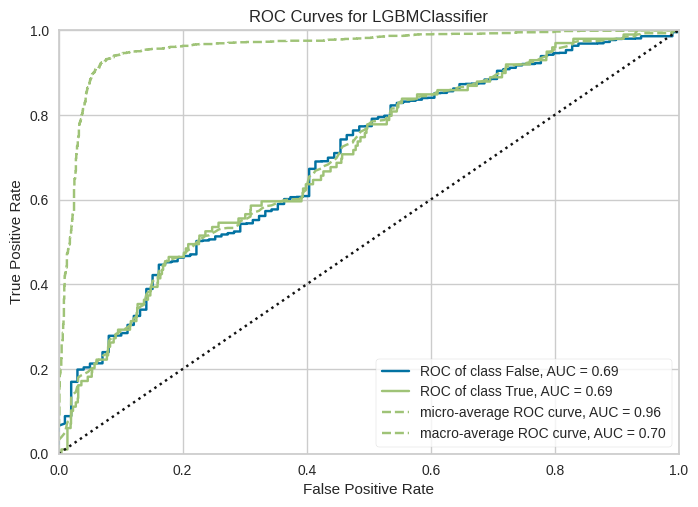

In [56]:
plot_model(tuned_lightgbm, plot='auc')

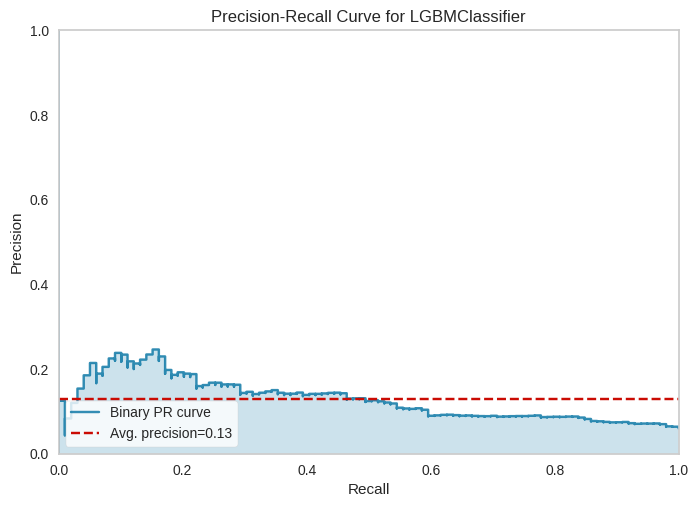

In [57]:
plot_model(tuned_lightgbm, plot='pr')

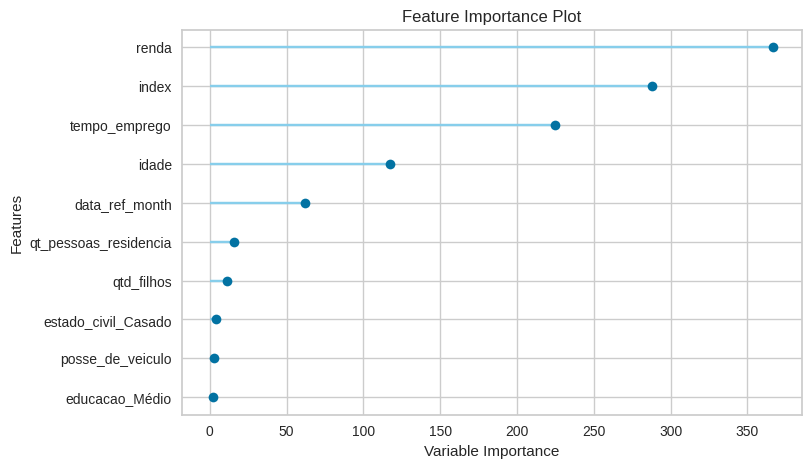

In [58]:
plot_model(tuned_lightgbm, plot='feature')

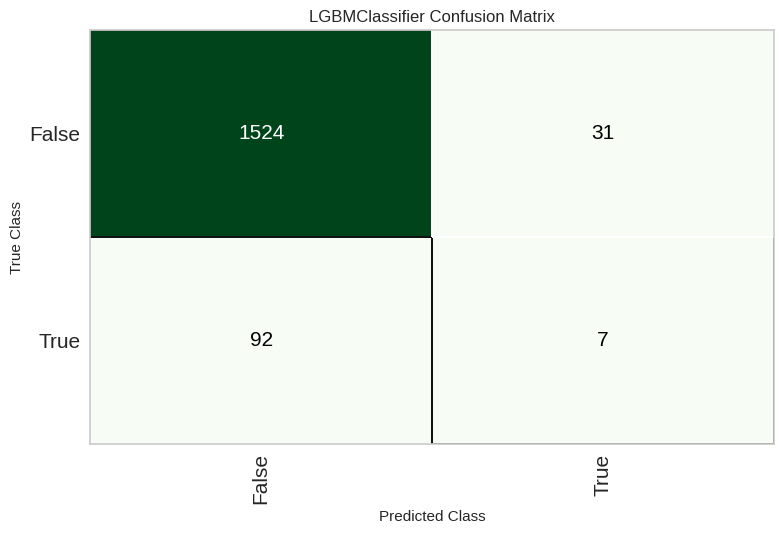

In [59]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [60]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9256,0.6935,0.0707,0.1842,0.1022,0.0714,0.0804


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
7774,2015-01-01,5618,F,N,N,0.0,Empresário,Superior completo,Separado,Casa,32,13.210958,1.0,7069.720215,True,0,0.9956
52175,2015-02-01,15959,F,N,S,1.0,Assalariado,Médio,Casado,Casa,39,8.547945,3.0,1932.189941,False,0,0.9937
24428,2015-01-01,4983,F,N,S,0.0,Pensionista,Fundamental,Casado,Casa,65,NaN,2.0,5405.370117,False,0,0.9984
172612,2015-04-01,7504,F,N,S,0.0,Assalariado,Médio,Casado,Casa,39,2.901370,2.0,18838.650391,False,0,0.9947
529307,2015-11-01,6072,F,N,S,0.0,Pensionista,Médio,Separado,Casa,62,NaN,1.0,8889.269531,True,0,0.9976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,2015-01-01,15277,F,N,N,0.0,Pensionista,Médio,Casado,Casa,56,NaN,2.0,2768.000000,False,0,0.9958
106352,2015-03-01,14649,F,N,S,2.0,Servidor público,Médio,União,Casa,34,7.219178,4.0,20160.910156,False,0,0.9987
356549,2015-08-01,8841,F,S,S,2.0,Servidor público,Médio,Casado,Casa,36,14.386301,4.0,37168.648438,False,0,0.9906
345414,2015-07-01,16267,F,N,S,1.0,Empresário,Médio,União,Casa,32,8.128767,3.0,76863.453125,False,0,0.9997


In [61]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [62]:
#Parâmetros finais do modelo Random Forest para deploy
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=Sim...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.5,
                                importance_type='split', lear

In [63]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9933,0.9985,0.8990,0.9889,0.9418,0.9383,0.9395


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
7774,2015-01-01,5618,F,N,N,0.0,Empresário,Superior completo,Separado,Casa,32,13.210958,1.0,7069.720215,True,1,0.8744
52175,2015-02-01,15959,F,N,S,1.0,Assalariado,Médio,Casado,Casa,39,8.547945,3.0,1932.189941,False,0,0.9040
24428,2015-01-01,4983,F,N,S,0.0,Pensionista,Fundamental,Casado,Casa,65,NaN,2.0,5405.370117,False,0,0.9989
172612,2015-04-01,7504,F,N,S,0.0,Assalariado,Médio,Casado,Casa,39,2.901370,2.0,18838.650391,False,0,0.9971
529307,2015-11-01,6072,F,N,S,0.0,Pensionista,Médio,Separado,Casa,62,NaN,1.0,8889.269531,True,1,0.7864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,2015-01-01,15277,F,N,N,0.0,Pensionista,Médio,Casado,Casa,56,NaN,2.0,2768.000000,False,0,0.9937
106352,2015-03-01,14649,F,N,S,2.0,Servidor público,Médio,União,Casa,34,7.219178,4.0,20160.910156,False,0,0.9981
356549,2015-08-01,8841,F,S,S,2.0,Servidor público,Médio,Casado,Casa,36,14.386301,4.0,37168.648438,False,0,0.9986
345414,2015-07-01,16267,F,N,S,1.0,Empresário,Médio,União,Casa,32,8.128767,3.0,76863.453125,False,0,0.9983


In [64]:
unseen_predictions = predict_model(final_lightgbm, data=df_valid)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8101,0.6147,0.1700,0.2833,0.2125,0.1121,0.1168


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
600037,2016-01-01,16259,F,N,S,0.0,Pensionista,Médio,Solteiro,Casa,61,NaN,1.0,7757.140137,False,0,0.9553
632583,2016-01-01,1621,F,N,S,1.0,Empresário,Médio,Casado,Casa,42,2.895890,3.0,1495.420044,False,0,0.5596
733218,2016-03-01,15497,F,N,S,0.0,Pensionista,Fundamental,Solteiro,Casa,60,NaN,1.0,1000.989990,True,0,0.6343
726430,2016-03-01,14202,F,N,S,1.0,Assalariado,Médio,Casado,Casa,30,0.369863,3.0,1064.910034,False,1,0.5824
692570,2016-02-01,9827,F,N,N,0.0,Assalariado,Médio,Casado,Com os pais,27,4.515069,2.0,544.789978,False,0,0.9893


In [72]:
score = accuracy_score(unseen_predictions.mau, unseen_predictions.prediction_label)
print(f"Acurácia: {score*100:.2f}%")

Acurácia: 81.01%


In [95]:
dump(final_lightgbm, "./data/final_lightgbm")

NameError: name 'final_lightgbm' is not defined